In [1]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from pyvis.network import Network
import numpy as np
from tqdm import tqdm
import random

from networkx.algorithms.centrality import edge_betweenness_centrality

from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from functools import partial
from multiprocessing import Pool


from scipy.cluster.hierarchy import dendrogram

from wordcloud import WordCloud

import re
import plotly.graph_objects as go

import heapq

import os
import pickle

from datetime import datetime

from collections import deque
%matplotlib inline

In [16]:
# Définir le chemin de base
base_path = Path('Dataset') / 'wikipedia' / 'chameleon'

# Charger les données
with (base_path / 'musae_chameleon_features.json').open('r') as f:
    features = json.load(f)

edges = pd.read_csv(base_path / 'musae_chameleon_edges.csv')
targets = pd.read_csv(base_path / 'musae_chameleon_target.csv')


names = pd.read_csv('data/wiki-topcats-page-names.txt.gz', compression='gzip', header=None, sep='\t', quotechar='"')

In [7]:
import wikipediaapi
base_path = Path('Dataset') / 'wikipedia' / 'chameleon'

# Charger les fichiers
with open(base_path / "musae_chameleon_features.json", "r") as f:
    features = json.load(f)  # Caractéristiques des nœuds
targets = pd.read_csv(base_path / "musae_chameleon_target.csv")  # Trafic mensuel moyen

# Exemple : Explorer les mots-clés et cibles pour un nœud
node_id = 0
keywords = features.get(str(node_id), [])
target = targets[targets['id'] == node_id]['target'].values[0] if node_id in targets['id'].values else None

print(f"Nœud {node_id} - Mots-clés : {keywords}, Trafic : {target}")



# Définir un user-agent personnalisé
user_agent = "MyApp/1.0 (https://example.com; contact@example.com)"
wiki = wikipediaapi.Wikipedia(user_agent=user_agent, language='en')

# Exemple avec un nœud spécifique
node_id = 0  # Identifiant du nœud
keywords = features.get(str(node_id), [])  # Obtenir les mots-clés associés au nœud

# Vérifier si des mots-clés sont disponibles
if keywords:
    # Convertir les mots-clés en chaînes et construire une requête
    query = " ".join(map(str, keywords[:3]))  # Prendre les 3 premiers mots-clés
    page = wiki.page(query)

    if page.exists():
        print(f"Article trouvé pour le nœud {node_id} : {page.title}")
        print(f"Résumé : {page.summary[:200]}")
    else:
        print(f"Aucun article trouvé pour le nœud {node_id}.")
else:
    print(f"Aucun mot-clé disponible pour le nœud {node_id}.")

Nœud 0 - Mots-clés : [434, 2749, 211, 226, 3127, 1123, 1028, 1716, 1697, 233, 154, 2839, 2307, 2117, 2842, 2787], Trafic : 171
Aucun article trouvé pour le nœud 0.


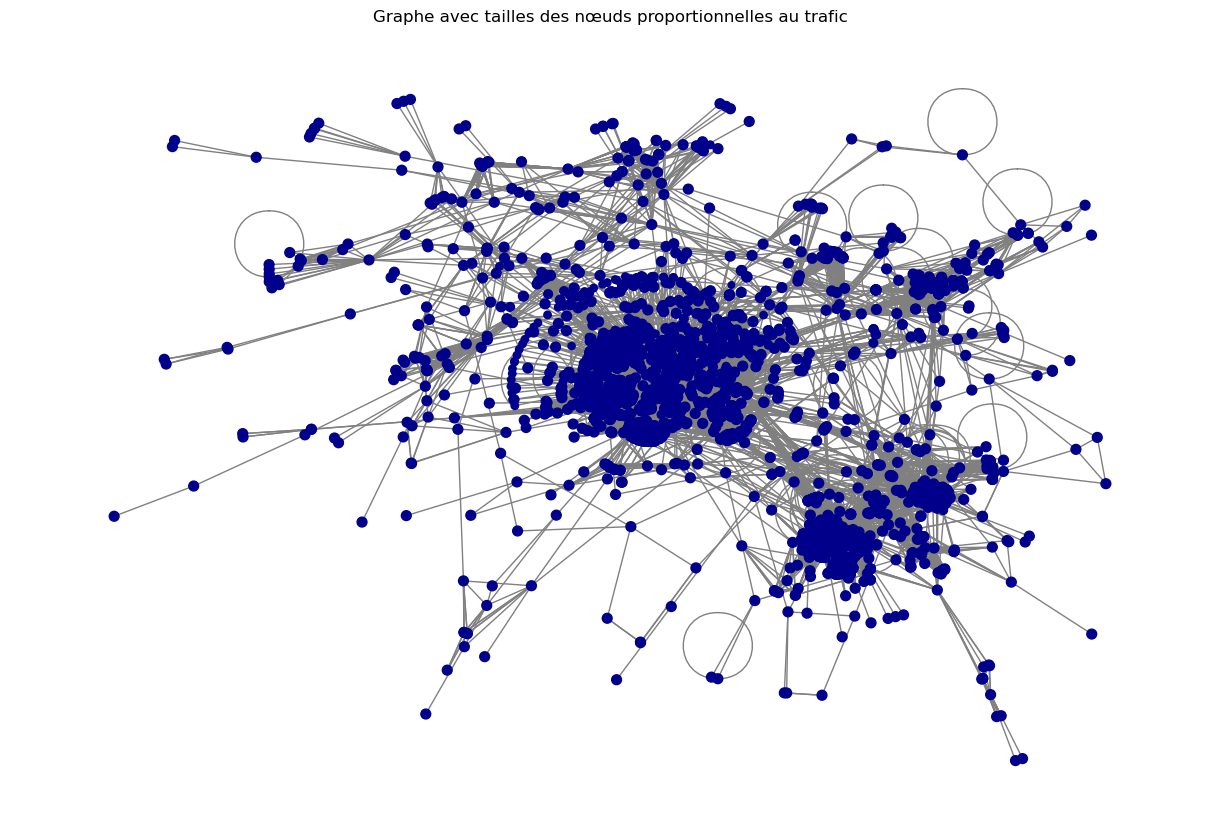

In [50]:
# Créer le graphe
G = nx.Graph()

# Ajouter les nœuds avec leurs attributs
for node, attrs in features.items():
    G.add_node(int(node), features=attrs)

# Ajouter les arêtes
for _, row in edges.iterrows():
    G.add_edge(row['id1'], row['id2'])

# Ajouter les cibles comme attributs des nœuds
for _, row in targets.iterrows():
    if int(row['id']) in G.nodes:
        G.nodes[int(row['id'])]['target'] = row['target']

# Préparer les tailles des nœuds en fonction du trafic
node_sizes = [min(50, max(10, G.nodes[node].get('target', 0) ** 0.5 * 5)) for node in G.nodes]

labels = {node: G.nodes[node].get('target', 0) for node in G.nodes}
# Position des nœuds
pos = nx.spring_layout(G, seed=42)

# Tracer le graphe avec tailles des nœuds proportionnelles au trafic
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos,
    node_size=node_sizes,  # Tailles des nœuds proportionnelles au trafic
    with_labels=False,  # Ajouter les labels des nœuds (optionnel)
    node_color="darkblue",  # Couleur uniforme pour les nœuds
    edge_color="gray"  # Couleur des arêtes
)

plt.title("Graphe avec tailles des nœuds proportionnelles au trafic")
plt.show()

In [51]:
G.number_of_nodes(), G.number_of_edges()

(2277, 31421)

# Betweeness

## "Brut force" algorithm

In [ ]:
def brute_force_algorithm_edge_betweenness(graph,k=None):
    edge_betweenness = {edge: 0 for edge in graph.edges()}

    nodes = list(graph.nodes())

    if k is not None and k < len(nodes):
        random.seed(10) 
        sources = random.sample(nodes, k)  # Choisir aléatoirement k nœuds sources
    else:
        sources = nodes  # Utiliser tous les nœuds


    for s in sources:
        node_time  = {noeud: float('inf') for noeud in graph.nodes()}
        node_time[s] = 0


        previous_edges = {noeud: [[],0] for noeud in graph.nodes()}

        Q = deque([s])

        while Q:
            visited_node = Q.popleft()
            for neighbor in graph.neighbors(visited_node):
                if node_time[neighbor] == float('inf'):
                    node_time[neighbor] = node_time[visited_node] + 1
                    edge = (visited_node, neighbor) if (visited_node, neighbor) in edge_betweenness else (neighbor, visited_node)
                    previous_edges[neighbor][0] = previous_edges[visited_node][0] + [edge]
                    previous_edges[neighbor][1] = 1
                    Q.append(neighbor)
                
                elif node_time[neighbor] == node_time[visited_node] + 1:
                    edge = (visited_node, neighbor) if (visited_node, neighbor) in edge_betweenness else (neighbor, visited_node)
                    #previous_edges[neighbor][0] = list(set(previous_edges[neighbor][0] + previous_edges[visited_node][0] + [edge]))
                    previous_edges[neighbor][0] += previous_edges[visited_node][0] + [edge]
                    previous_edges[neighbor][1] += 1



        for edges in previous_edges.values():
            if edges[1] == 1:
                for edge in edges[0]:
                    edge_betweenness[edge] += 1
            elif edges[1] > 1:
                for edge in edges[0]:
                    edge_betweenness[edge] += 1/edges[1]

    if not graph.is_directed():
        for edge in edge_betweenness:
            edge_betweenness[edge] /= 2.0
    return(edge_betweenness)

                

def remove_edges_with_highest_betweenness_brut_force(graph,number_edges_to_compute=10, num_edges_to_remove=1000, k=None):
    graph = graph.copy()  #Travail sur une copie pour préserver l'original
    liste_betweness = []
    liste_number_clusters = []
    liste_partial_clusters = []
    # Supprimer les arêtes avec la plus grande betweeness
    for _ in tqdm(range(0,num_edges_to_remove,number_edges_to_compute), desc="Suppression des arêtes"):
        edge_betweenness = brute_force_algorithm_edge_betweenness(graph,k=k)
        top_edges = heapq.nlargest(number_edges_to_compute,  # Nombre d'arêtes à sélectionner
            edge_betweenness.items(),  # `items()` retourne des tuples (arête, betweenness)
            key=lambda x: x[1]  # Trier par la valeur de betweenness
        )
            # Supprimer les `number_edges_to_compute` arêtes
        for edge, betweenness in top_edges:
            graph.remove_edge(*edge)
            liste_betweness.append(betweenness)
        partial_clusters = list(nx.connected_components(graph))
        liste_partial_clusters.append(partial_clusters)
        liste_number_clusters.append(len(partial_clusters)) 
        


    # Extraire les clusters à partir des composantes connectées
    clusters = list(nx.connected_components(graph))
    

    return graph, clusters, liste_betweness, liste_number_clusters, liste_partial_clusters              
            
            

## More effective algorithm: use of Brandes method

In [ ]:
def edge_betweeness_Brandes_method(graph,k=None):
    edge_betweenness = {edge: 0 for edge in graph.edges()}

    nodes = list(graph.nodes())

    if k is not None and k < len(nodes):
        random.seed(10) 
        sources = random.sample(nodes, k)  # Choisir aléatoirement k nœuds sources
    else:
        sources = nodes  # Utiliser tous les nœuds


    for s in sources:
        Pred = {w: [] for w in graph.nodes()}
        dist = {t: float('inf') for t in graph.nodes()}
        sigma = {t: 0 for t in graph.nodes()}
        delta = {t: 0 for t in graph.nodes()}

        dist[s] = 0
        sigma[s] = 1
        Q = [s]
        S = []

        while Q:
            v = Q.pop(0)
            S.append(v)
            for w in graph.neighbors(v):
                if dist[w] == float('inf'):
                    dist[w] = dist[v] + 1
                    Q.append(w)
                if dist[w] == dist[v] + 1:
                    sigma[w] += sigma[v]
                    Pred[w].append(v)

        for v in graph.nodes():
            delta[v] = 0
        
        while S:
            w = S.pop()
            for v in Pred[w]:
                c = (sigma[v] / sigma[w]) * (1 + delta[w])
                edge = (v, w) if (v, w) in edge_betweenness else (w, v)
                edge_betweenness[edge] += c
                delta[v] += c
                
                    
    if not graph.is_directed():
        for edge in edge_betweenness:
            edge_betweenness[edge] /= 2.0

    return edge_betweenness
        


def remove_edges_with_highest_betweenness_Brandes(graph,number_edges_to_compute=10, num_edges_to_remove=1000, k=None):
    """
    Supprime les `num_edges` arêtes ayant la plus grande betweeness centrality,
    tout en recalculant la centralité après chaque suppression, et retourne les clusters.
    
    Arguments :
        graph : networkx.Graph
            Le graphe sur lequel effectuer la suppression.
        num_edges : int
            Nombre d'arêtes à supprimer.
        k : int
            Paramètre pour l'approximation de la centralité.
    
    Retourne :
        modified_graph : networkx.Graph
            Le graphe après suppression des arêtes.
        clusters_numpy : np.ndarray
            Les clusters convertis en un tableau NumPy.
    """
    graph = graph.copy()  # Travaillez sur une copie pour préserver l'original
    liste_betweness = []
    liste_number_clusters = []
    liste_partial_clusters = []
    # Supprimer les arêtes avec la plus grande betweeness
    for _ in tqdm(range(0,num_edges_to_remove,number_edges_to_compute), desc="Suppression des arêtes"):
        edge_betweenness = edge_betweeness_Brandes_method(graph,k=k)
        top_edges = heapq.nlargest(number_edges_to_compute,  # Nombre d'arêtes à sélectionner
            edge_betweenness.items(),  # `items()` retourne des tuples (arête, betweenness)
            key=lambda x: x[1]  # Trier par la valeur de betweenness
        )
            # Supprimer les `number_edges_to_compute` arêtes
        for edge, betweenness in top_edges:
            graph.remove_edge(*edge)
            liste_betweness.append(betweenness)
        partial_clusters = list(nx.connected_components(graph))
        liste_partial_clusters.append(partial_clusters)
        liste_number_clusters.append(len(partial_clusters)) 
        


    # Extraire les clusters à partir des composantes connectées
    clusters = list(nx.connected_components(graph))
    

    return graph, clusters, liste_betweness, liste_number_clusters, liste_partial_clusters

## Algorithm implemented in networkx

In [5]:
def remove_edges_with_highest_betweenness_networkx(graph,number_edges_to_compute=10, num_edges_to_remove=1000, k=500):
    """
    Supprime les `num_edges` arêtes ayant la plus grande betweeness centrality,
    tout en recalculant la centralité après chaque suppression, et retourne les clusters.
    
    Arguments :
        graph : networkx.Graph
            Le graphe sur lequel effectuer la suppression.
        num_edges : int
            Nombre d'arêtes à supprimer.
        k : int
            Paramètre pour l'approximation de la centralité.
    
    Retourne :
        modified_graph : networkx.Graph
            Le graphe après suppression des arêtes.
        clusters_numpy : np.ndarray
            Les clusters convertis en un tableau NumPy.
    """
    graph = graph.copy()  # Travaillez sur une copie pour préserver l'original
    liste_betweness = []
    liste_number_clusters = []
    liste_partial_clusters = []
    # Supprimer les arêtes avec la plus grande betweeness
    for _ in tqdm(range(0,num_edges_to_remove,number_edges_to_compute), desc="Suppression des arêtes"):
        edge_betweenness = nx.edge_betweenness_centrality(graph, k=k, seed=10)
        #edge_betweenness = brandes_betweenness_with_k(graph, k=k)
        top_edges = heapq.nlargest(number_edges_to_compute,  # Nombre d'arêtes à sélectionner
            edge_betweenness.items(),  # `items()` retourne des tuples (arête, betweenness)
            key=lambda x: x[1]  # Trier par la valeur de betweenness
        )
            # Supprimer les `number_edges_to_compute` arêtes
        for edge, betweenness in top_edges:
            graph.remove_edge(*edge)
            liste_betweness.append(betweenness)
        partial_clusters = list(nx.connected_components(graph))
        liste_partial_clusters.append(partial_clusters)
        liste_number_clusters.append(len(partial_clusters)) 
        


    # Extraire les clusters à partir des composantes connectées
    clusters = list(nx.connected_components(graph))
    

    return graph, clusters, liste_betweness, liste_number_clusters, liste_partial_clusters



## Functions to plot the clusters

In [68]:
def visualize_clusters(graph, clusters, title="Visualisation des clusters (Matplotlib)"):
    """
    Visualise les clusters extraits en coloriant chaque cluster différemment avec Matplotlib.
    
    Arguments :
        graph : networkx.Graph
            Le graphe à visualiser.
        clusters : list of sets
            Une liste où chaque élément est un ensemble de nœuds appartenant à un cluster.
        title : str
            Le titre du graphique.
    """
    pos = nx.spring_layout(graph, seed=42)  # Générer une disposition stable
    colors = plt.cm.get_cmap("hsv", len(clusters))
    #colors = plt.cm.get_cmap("tab20", len(clusters))  # Palette de couleurs pour les clusters
    
    plt.figure(figsize=(10, 7))

    # Dessiner les nœuds, colorés par cluster
    for i, cluster in enumerate(clusters):
        nx.draw_networkx_nodes(
            graph, pos,
            nodelist=list(cluster),  # Convertir l'ensemble en liste
            node_size=300,
            node_color=[colors(i)],
            label=f"Cluster {i + 1}"
        )
    
    # Dessiner les arêtes restantes
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    
    plt.legend()
    plt.title(title)
    plt.show()


def visualize_clusters_plotly(graph, clusters, title="Visualisation des clusters (Plotly)"):
    """
    Visualise les clusters extraits en coloriant chaque cluster différemment avec Plotly.
    
    Arguments :
        graph : networkx.Graph
            Le graphe à visualiser.
        clusters : list of sets
            Une liste où chaque élément est un ensemble de nœuds appartenant à un cluster.
        title : str
            Le titre du graphique.
    """
    pos = nx.spring_layout(graph, seed=42)  # Disposition des nœuds
    edge_x = []
    edge_y = []

    # Dessiner les arêtes
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines"
    )

    # Dessiner les nœuds
    node_traces = []
    colors = plt.cm.get_cmap("hsv", len(clusters))
    #colors = plt.cm.get_cmap("tab20", len(clusters))
    
    for i, cluster in enumerate(clusters):
        node_x = []
        node_y = []
        for node in cluster:
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode="markers",
            marker=dict(
                size=10,
                color=f"rgba({int(colors(i)[0]*255)}, {int(colors(i)[1]*255)}, {int(colors(i)[2]*255)}, 0.8)",
                line_width=2
            ),
            name=f"Cluster {i + 1}"
        )
        node_traces.append(node_trace)
    
    # Créer la figure
    fig = go.Figure(data=[edge_trace] + node_traces,
                    layout=go.Layout(
                        title=title,
                        titlefont_size=16,
                        showlegend=True,
                        hovermode="closest",
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))
    fig.show(renderer="browser")


def global_modularity(clusters, G):
    """
    Calcule la modularité globale d'un graphe donné et d'un ensemble de clusters.

    Arguments :
        clusters : list of sets
            Une liste où chaque élément est un ensemble de nœuds appartenant à un cluster.
        G : networkx.Graph
            Le graphe pour lequel calculer la modularité.

    Retourne :
        Q : float
            La modularité globale du graphe pour les clusters donnés.
    """
    m = G.number_of_edges()  # Nombre total d'arêtes
    if m == 0:
        raise ValueError("Le graphe ne contient aucune arête, la modularité ne peut pas être calculée.")

    # Initialiser la modularité
    Q = 0

    # Itérer sur chaque cluster
    for cluster in clusters:
        # Convertir le cluster en liste (au cas où il serait un set)
        cluster_nodes = list(cluster)

        # Sous-graphe correspondant au cluster
        subgraph = G.subgraph(cluster_nodes)

        # Calculer les termes de la modularité pour ce cluster
        L_c = subgraph.number_of_edges()  # Arêtes à l'intérieur du cluster
        k_c = sum(G.degree(n) for n in cluster_nodes)  # Somme des degrés des nœuds du cluster

        # Contribution à la modularité
        Q += (L_c / m) - (k_c / (2 * m)) ** 2

    return Q


def create_and_generate_wordclouds(clusters, names):
    """
    Creates a dictionary of clusters with their associated phrases and generates Word Clouds for each cluster.

    Parameters:
        clusters (list of sets): A list of clusters where each cluster is a set of indices.
        names (list of lists): A list of names corresponding to the indices.

    Returns:
        dictionary_clusters (dict): A dictionary where keys are cluster IDs and values are lists of phrases.
    """
    # Step 1: Create the dictionary of clusters
    dictionary_clusters = {}
    for i in range(len(clusters)):
        cluster_list = []
        for j in clusters[i]:
            cluster_list.append(names[0][j])
        dictionary_clusters[i] = cluster_list

    # Step 2: Generate Word Clouds for each cluster
    for cluster_id, cluster_phrases in dictionary_clusters.items():
        # Combine all phrases from the cluster
        text = ' '.join(cluster_phrases).lower()
        text = ' '.join(set(text.split()))  # Remove duplicates
        text = re.sub(r'[^\w\s]', '', text)  # Remove non-alphanumeric characters
        text = text.lower()

        print(f"Cluster {cluster_id + 1}: {text[:100]}...")  # Preview the first 100 characters

        # Generate the Word Cloud
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

        # Display the Word Cloud
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Cluster {cluster_id + 1}")
        plt.show()

    return dictionary_clusters

## Tests of different algorithms

In [58]:
# Création d'un graphe non dirigé plus complexe
G_undirected = nx.Graph()

# Ajouter des nœuds et des arêtes
G_undirected.add_edges_from([
    (0, 1), (0, 2), (1, 2), (1, 3), 
    (2, 4), (3, 4), (3, 5), (4, 5)
])

# Run the custom edge betweenness algorithm
original_result_undirected = brute_force_algorithm_edge_betweenness(G_undirected)

# Run the approximate edge betweenness algorithm
custom_result_undirected = edge_betweeness_Brandes_method(G_undirected)

# Run NetworkX's exact edge betweenness centrality
nx_result_undirected = nx.edge_betweenness_centrality(G_undirected, normalized=False)

# Display results
print("\n--- orgiinal Edge Betweenness ---")
print(original_result_undirected)

print("\n--- custom Brandes Edge Betweenness ---")
print(custom_result_undirected)

print("\n--- NetworkX Edge Betweenness ---")
print(nx_result_undirected)


--- orgiinal Edge Betweenness ---
{(0, 1): 2.5, (0, 2): 2.5, (1, 2): 2.0, (1, 3): 4.5, (2, 4): 4.5, (3, 4): 2.0, (3, 5): 2.5, (4, 5): 2.5}

--- custom Brandes Edge Betweenness ---
{(0, 1): 2.5, (0, 2): 2.5, (1, 2): 2.0, (1, 3): 4.5, (2, 4): 4.5, (3, 4): 2.0, (3, 5): 2.5, (4, 5): 2.5}

--- NetworkX Edge Betweenness ---
{(0, 1): 2.5, (0, 2): 2.5, (1, 2): 2.0, (1, 3): 4.5, (2, 4): 4.5, (3, 4): 2.0, (3, 5): 2.5, (4, 5): 2.5}


In [59]:
# Création d'un graphe non dirigé plus complexe
G_undirected = nx.Graph()

# Ajouter des nœuds et des arêtes
G_undirected.add_edges_from([
    (0, 1), (1, 2), (2, 3), (3, 4), 
    (3, 5), (3, 6)])

# Run the custom edge betweenness algorithm
original_result_undirected = brute_force_algorithm_edge_betweenness(G_undirected)

# Run the approximate edge betweenness algorithm
custom_result_undirected = edge_betweeness_Brandes_method(G_undirected)

# Run NetworkX's exact edge betweenness centrality
nx_result_undirected = nx.edge_betweenness_centrality(G_undirected, normalized=False)

# Display results
print("\n--- orgiinal Edge Betweenness ---")
print(original_result_undirected)

print("\n--- custom Brandes Edge Betweenness ---")
print(custom_result_undirected)

print("\n--- NetworkX Edge Betweenness ---")
print(nx_result_undirected)


--- orgiinal Edge Betweenness ---
{(0, 1): 6.0, (1, 2): 10.0, (2, 3): 12.0, (3, 4): 6.0, (3, 5): 6.0, (3, 6): 6.0}

--- custom Brandes Edge Betweenness ---
{(0, 1): 6.0, (1, 2): 10.0, (2, 3): 12.0, (3, 4): 6.0, (3, 5): 6.0, (3, 6): 6.0}

--- NetworkX Edge Betweenness ---
{(0, 1): 6.0, (1, 2): 10.0, (2, 3): 12.0, (3, 4): 6.0, (3, 5): 6.0, (3, 6): 6.0}


## Test on Chameleons

Suppression des arêtes: 100%|██████████| 80/80 [00:08<00:00,  9.06it/s]
C:\Users\antoi\AppData\Local\Temp\ipykernel_38564\3588108038.py:63: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



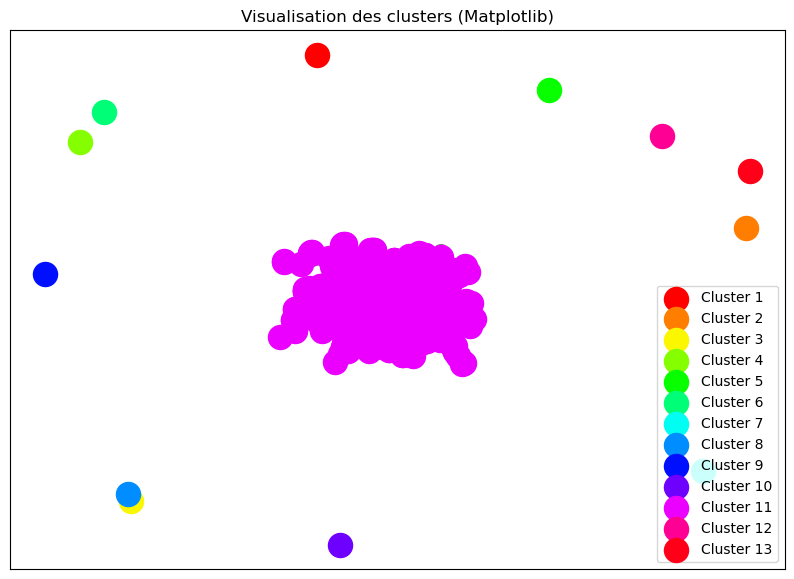

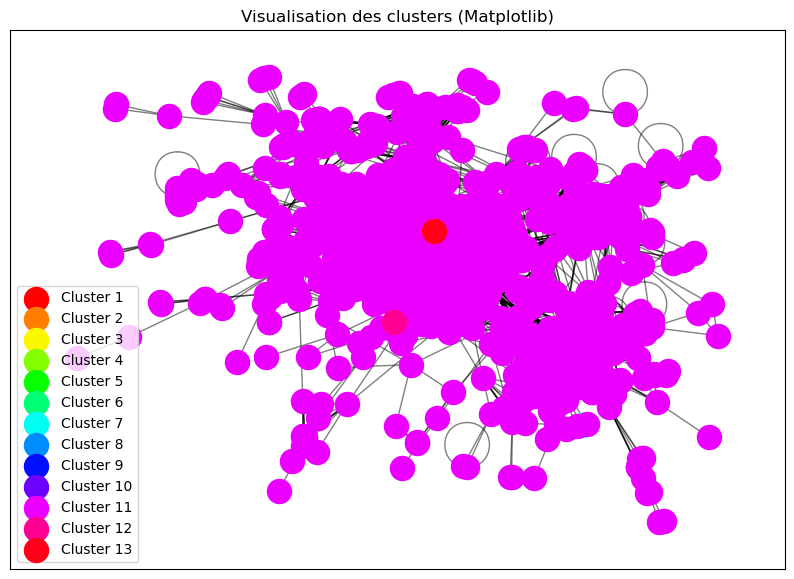

C:\Users\antoi\AppData\Local\Temp\ipykernel_38564\3588108038.py:118: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



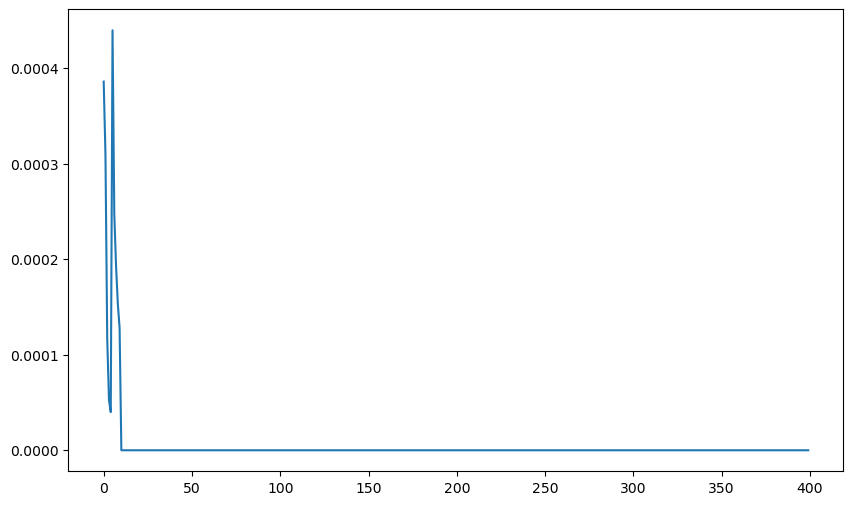

In [ ]:
G2,clusters,betwenness, liste_number_clusters, liste_partial_clusters = remove_edges_with_highest_betweenness_networkx(G,number_edges_to_compute=5, num_edges_to_remove=400, k=None)
# Visualiser les clusters
visualize_clusters(G2, clusters)
visualize_clusters(G, clusters)
visualize_clusters_plotly(G, clusters)

plt.figure(figsize=(10, 6))
plt.plot(betwenness)

Suppression des arêtes: 100%|██████████| 80/80 [00:07<00:00, 10.59it/s]
C:\Users\antoi\AppData\Local\Temp\ipykernel_38564\3588108038.py:63: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



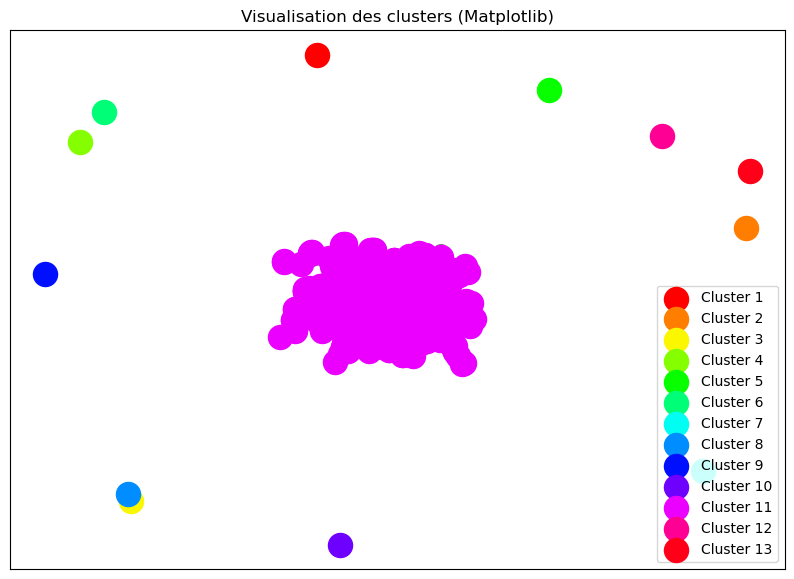

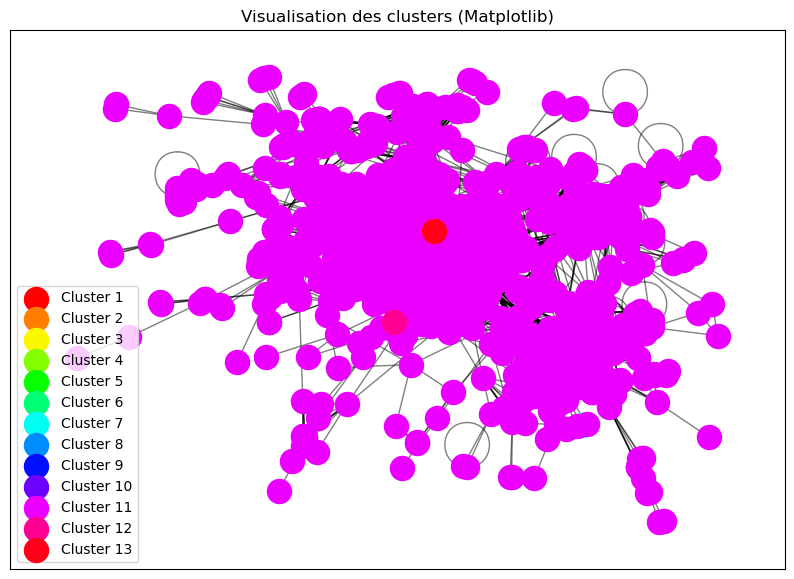

C:\Users\antoi\AppData\Local\Temp\ipykernel_38564\3588108038.py:118: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [ ]:
G2,clusters,betwenness, liste_number_clusters, liste_partial_clusters = remove_edges_with_highest_betweenness_Brandes(G,number_edges_to_compute=5, num_edges_to_remove=400, k=None)
# Visualiser les clusters
visualize_clusters(G2, clusters)
visualize_clusters(G, clusters)
visualize_clusters_plotly(G, clusters)

plt.figure(figsize=(10, 6))
plt.plot(betwenness)



## Functions to save and load the data

In [11]:
def save_outputs(graph, clusters, betweenness, liste_number_clusters, liste_partial_clusters, custom_string="", params=None):
    """
    Sauvegarde les différentes sorties dans des fichiers appropriés, dans un dossier structuré par date et chaîne personnalisée.

    Arguments :
        graph : networkx.Graph
            Le graphe résultant après suppression des arêtes.
        clusters : list of sets
            Les clusters obtenus.
        betweenness : list
            Liste des valeurs de betweenness des arêtes supprimées.
        liste_number_clusters : list
            Historique du nombre de clusters.
        liste_partial_clusters : list
            Historique des clusters partiels.
        custom_string : str
            Une chaîne personnalisable pour le nom du dossier de sortie.
        params : dict
            Dictionnaire contenant les paramètres utilisés (par exemple : `number_edges_to_compute`, `num_edges_to_remove`, etc.).
    """
    # Créer le nom du dossier avec la date et la chaîne personnalisée
    today = datetime.now().strftime("%Y-%m-%d")  # Date au format YYYY-MM-DD
    output_dir = f"Clustering_{today}_{custom_string}"
    os.makedirs(output_dir, exist_ok=True)  # Créer le répertoire s'il n'existe pas

    # Sauvegarder le graphe résultant au format pickle
    with open(f"{output_dir}/graph.pkl", "wb") as f:
        pickle.dump(graph, f)

    # Sauvegarder les clusters au format JSON (convertir les types)
    clusters_list = [list(map(int, cluster)) for cluster in clusters]  # Convertir en listes d'int
    with open(f"{output_dir}/clusters.json", "w") as f:
        json.dump(clusters_list, f, indent=4)

    # Sauvegarder les valeurs de betweenness dans un fichier texte
    betweenness = [float(b) for b in betweenness]  # Convertir les valeurs en float natifs
    np.savetxt(f"{output_dir}/betweenness.txt", betweenness)

    # Convertir liste_number_clusters en types Python natifs avant JSON
    liste_number_clusters = [int(x) for x in liste_number_clusters]
    with open(f"{output_dir}/liste_number_clusters.json", "w") as f:
        json.dump(liste_number_clusters, f, indent=4)

    # Sauvegarder liste_partial_clusters en JSON (convertir les types)
    partial_clusters_list = [
        [list(map(int, cluster)) for cluster in partial] for partial in liste_partial_clusters
    ]
    with open(f"{output_dir}/liste_partial_clusters.json", "w") as f:
        json.dump(partial_clusters_list, f, indent=4)

    # Sauvegarder les paramètres utilisés dans un fichier Excel
    if params is not None:
        # Convertir les types NumPy en types natifs pour JSON
        params = {key: (int(value) if isinstance(value, (np.integer, np.int64)) else value)
                  for key, value in params.items()}
        params_df = pd.DataFrame([params])  # Convertir le dictionnaire en DataFrame
        params_df.to_excel(f"{output_dir}/parameters.xlsx", index=False)
    
    print(f"Tous les outputs ont été sauvegardés dans le répertoire : {output_dir}")



def load_outputs(output_dir):
    """
    Recharge les données sauvegardées depuis un répertoire donné.

    Arguments :
        output_dir : str
            Chemin vers le répertoire où les données ont été sauvegardées.

    Retourne :
        graph : networkx.Graph
            Le graphe rechargé.
        clusters : list of sets
            Les clusters rechargés.
        betweenness : list
            Liste des valeurs de betweenness des arêtes supprimées.
        liste_number_clusters : list
            Historique du nombre de clusters.
        liste_partial_clusters : list of lists of sets
            Historique des clusters partiels.
        params : dict
            Les paramètres utilisés lors de la sauvegarde.
    """
    # Charger le graphe
    with open(f"{output_dir}/graph.pkl", "rb") as f:
        graph = pickle.load(f)

    # Charger les clusters
    with open(f"{output_dir}/clusters.json", "r") as f:
        clusters = [set(cluster) for cluster in json.load(f)]  # Reconvertir en sets

    # Charger les valeurs de betweenness
    betweenness = np.loadtxt(f"{output_dir}/betweenness.txt").tolist()

    # Charger l'historique du nombre de clusters
    with open(f"{output_dir}/liste_number_clusters.json", "r") as f:
        liste_number_clusters = json.load(f)

    # Charger les clusters partiels
    with open(f"{output_dir}/liste_partial_clusters.json", "r") as f:
        liste_partial_clusters = [
            [set(cluster) for cluster in partial] for partial in json.load(f)
        ]

    # Charger les paramètres
    params_file = f"{output_dir}/parameters.xlsx"
    if os.path.exists(params_file):
        params = pd.read_excel(params_file).to_dict(orient="records")[0]  # Convertir en dict
    else:
        params = None

    print(f"Toutes les données ont été rechargées depuis : {output_dir}")
    return graph, clusters, betweenness, liste_number_clusters, liste_partial_clusters, params



In [ ]:
save_outputs(G2, clusters, betwenness, liste_number_clusters, liste_partial_clusters, custom_string="Chameleons_custom", params={"number_edges_to_compute": 5, "num_edges_to_remove": 400})

Tous les outputs ont été sauvegardés dans le répertoire : Clustering_2024-12-09_Chameleons


In [34]:
# Chemin vers le répertoire de sauvegarde
output_dir = "Clustering_2024-12-09_Chameleons"

# Recharger les données
G_reloaded, clusters_reloaded, betweenness_reloaded, liste_number_clusters_reloaded, liste_partial_clusters_reloaded, params_reloaded = load_outputs(output_dir)

# Afficher les données rechargées
print("Nombre de nœuds dans le graphe :", G_reloaded.number_of_nodes())
print("Nombre de clusters :", len(clusters_reloaded))
print("Premiers clusters :", clusters_reloaded[:3])
print("Paramètres utilisés :", params_reloaded)

Toutes les données ont été rechargées depuis : Clustering_2024-12-09_Chameleons
Nombre de nœuds dans le graphe : 2277
Nombre de clusters : 23
Premiers clusters : [{3, 1539, 1031, 11, 527, 16, 2065, 2067, 2068, 2072, 26, 540, 28, 2077, 2080, 36, 1575, 1073, 2098, 562, 2101, 569, 2109, 63, 2112, 2113, 1601, 1092, 2116, 2118, 585, 1098, 2123, 74, 77, 2129, 1106, 83, 2131, 601, 1626, 91, 1116, 2141, 2142, 2143, 95, 97, 2148, 102, 1643, 110, 111, 624, 1137, 113, 115, 119, 635, 126, 127, 647, 1673, 138, 2187, 653, 656, 658, 2194, 148, 1173, 2198, 147, 665, 154, 668, 1694, 1183, 1185, 2214, 682, 1708, 1196, 1201, 1204, 1205, 1209, 187, 1212, 1213, 198, 1223, 719, 1744, 208, 1748, 2262, 726, 731, 1245, 221, 1761, 1764, 234, 237, 751, 239, 753, 1266, 243, 244, 1269, 1270, 1785, 1275, 1277, 769, 264, 1801, 265, 270, 783, 1297, 1299, 1308, 297, 811, 1324, 301, 302, 1840, 817, 818, 1846, 1851, 317, 1853, 1343, 832, 318, 1859, 838, 1354, 1362, 340, 1877, 1885, 349, 867, 1897, 1388, 1403, 1405, 382,

# Test on the big dataset (or subgraphs)

Nombre de nœuds : 1791489
Nombre d'arêtes : 25447873


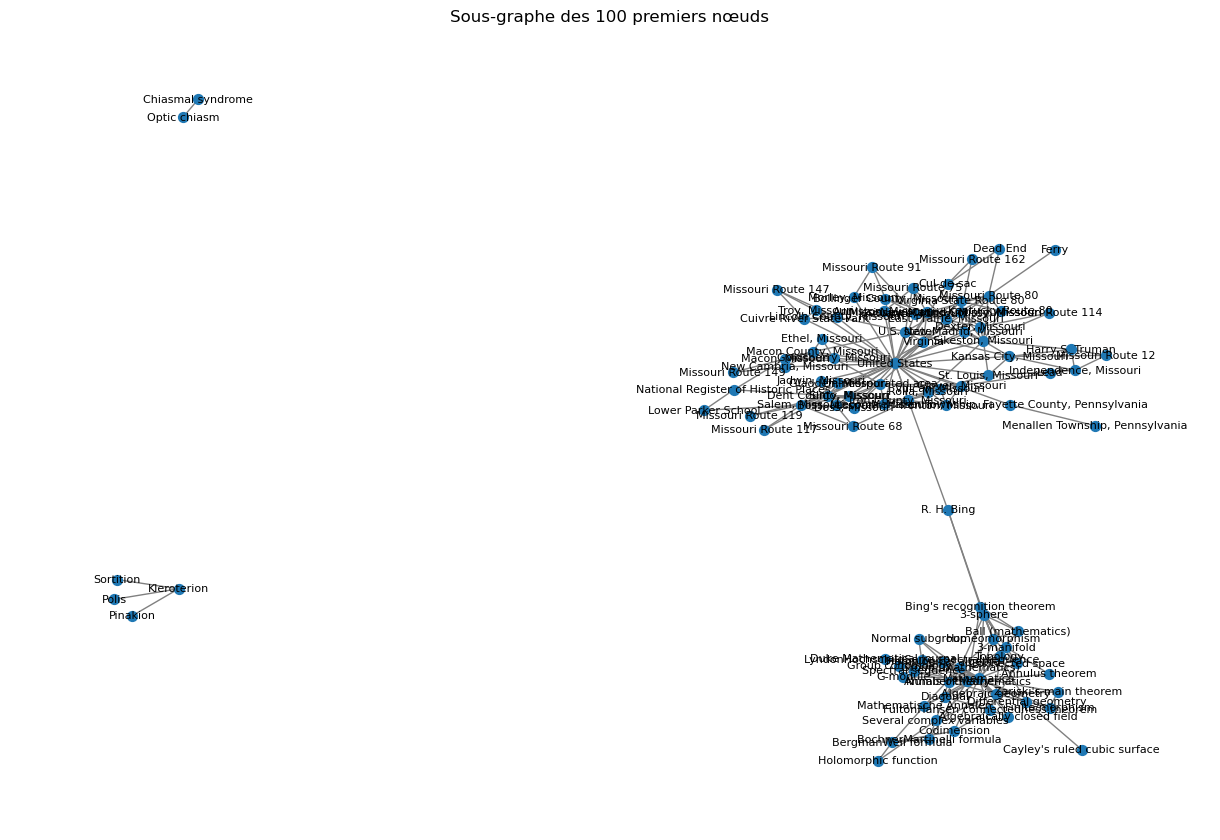

In [12]:
import gzip


# Charger les arêtes du graphe
def load_edges(file_path):
    edges = []
    with gzip.open(file_path, 'rt') as f:  # Ouvrir en mode texte
        for line in f:
            source, target = map(int, line.strip().split())
            edges.append((source, target))
    return edges

# Charger les noms des pages
def load_page_names(file_path):
    page_names = {}
    with gzip.open(file_path, 'rt') as f:  # Ouvrir en mode texte
        for line in f:
            line = line.strip()
            if not line:  # Ignorer les lignes vides
                continue
            parts = line.split(' ', 1)
            if len(parts) == 2:  # Vérifier que la ligne contient bien deux parties
                page_id, page_name = parts
                page_names[int(page_id)] = page_name
    return page_names

# Chemins vers les fichiers
base_path = "data/big_graph"
edges_file = f"{base_path}/wiki-topcats.txt.gz"
page_names_file = f"{base_path}/wiki-topcats-page-names.txt.gz"

# Charger les données
edges = load_edges(edges_file)
page_names = load_page_names(page_names_file)

# Créer le graphe
G = nx.Graph()
G.add_edges_from(edges)  # Ajouter les arêtes

# Ajouter les noms des pages comme attributs des nœuds
nx.set_node_attributes(G, page_names, "name")

# Informations sur le graphe
print(f"Nombre de nœuds : {G.number_of_nodes()}")
print(f"Nombre d'arêtes : {G.number_of_edges()}")

# Visualiser une sous-partie du graphe
subgraph = G.subgraph(list(G.nodes)[:100])  # Prenez un sous-graphe avec 100 nœuds
pos = nx.spring_layout(subgraph, seed=42)  # Layout pour la visualisation
plt.figure(figsize=(12, 8))
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    labels={node: G.nodes[node]["name"] for node in subgraph.nodes},  # Utiliser les noms des pages
    node_size=50,
    font_size=8,
    edge_color="gray",
)
plt.title("Sous-graphe des 100 premiers nœuds")
plt.show()

In [18]:
# 1. Vérifier les cycles
try:
    cycle = nx.find_cycle(G)
    print(f"Le graphe contient un cycle : {cycle}")
except nx.NetworkXNoCycle:
    print("Le graphe ne contient aucun cycle.")

# 2. Vérifier si le graphe est un DAG
if nx.is_directed_acyclic_graph(G):
    print("Le graphe est un DAG.")
else:
    print("Le graphe n'est pas un DAG.")

# 3. Trouver les self-loops
self_loops = list(nx.selfloop_edges(G))
print(f"Nombre de nœuds connectés à eux-mêmes (self-loops) : {len(self_loops)}")
if self_loops:
    print(f"Nœuds avec self-loops : {self_loops}")

# 4. Trouver les composantes connectées
connected_components = list(nx.connected_components(G))
print(f"Nombre de composantes connectées : {len(connected_components)}")
component_sizes = [len(component) for component in connected_components]
print(f"Taille des composantes connectées : {component_sizes}")

Le graphe contient un cycle : [(2704, 2517), (2517, 8752), (8752, 2718), (2718, 2714), (2714, 2704)]
Le graphe n'est pas un DAG.
Nombre de nœuds connectés à eux-mêmes (self-loops) : 3666
Nœuds avec self-loops : [(9227, 9227), (9587, 9587), (1174771, 1174771), (471303, 471303), (315158, 315158), (272754, 272754), (242551, 242551), (66963, 66963), (1537801, 1537801), (268, 268), (1535279, 1535279), (1537354, 1537354), (450070, 450070), (394841, 394841), (5364, 5364), (1452063, 1452063), (1184538, 1184538), (15452, 15452), (11679, 11679), (7592, 7592), (7170, 7170), (1090859, 1090859), (869680, 869680), (7778, 7778), (65266, 65266), (751034, 751034), (751056, 751056), (870741, 870741), (1061390, 1061390), (1066, 1066), (1611191, 1611191), (1179626, 1179626), (1028980, 1028980), (266011, 266011), (1060322, 1060322), (1185101, 1185101), (1164530, 1164530), (1161951, 1161951), (1164741, 1164741), (1064467, 1064467), (1063641, 1063641), (1065021, 1065021), (66700, 66700), (824223, 824223), (5

In [19]:
is_connected = nx.is_connected(G)
print(f"Le graphe est connexe : {is_connected}")

Le graphe est connexe : True


Nombre de nœuds : 1000
Nombre d'arêtes : 4628


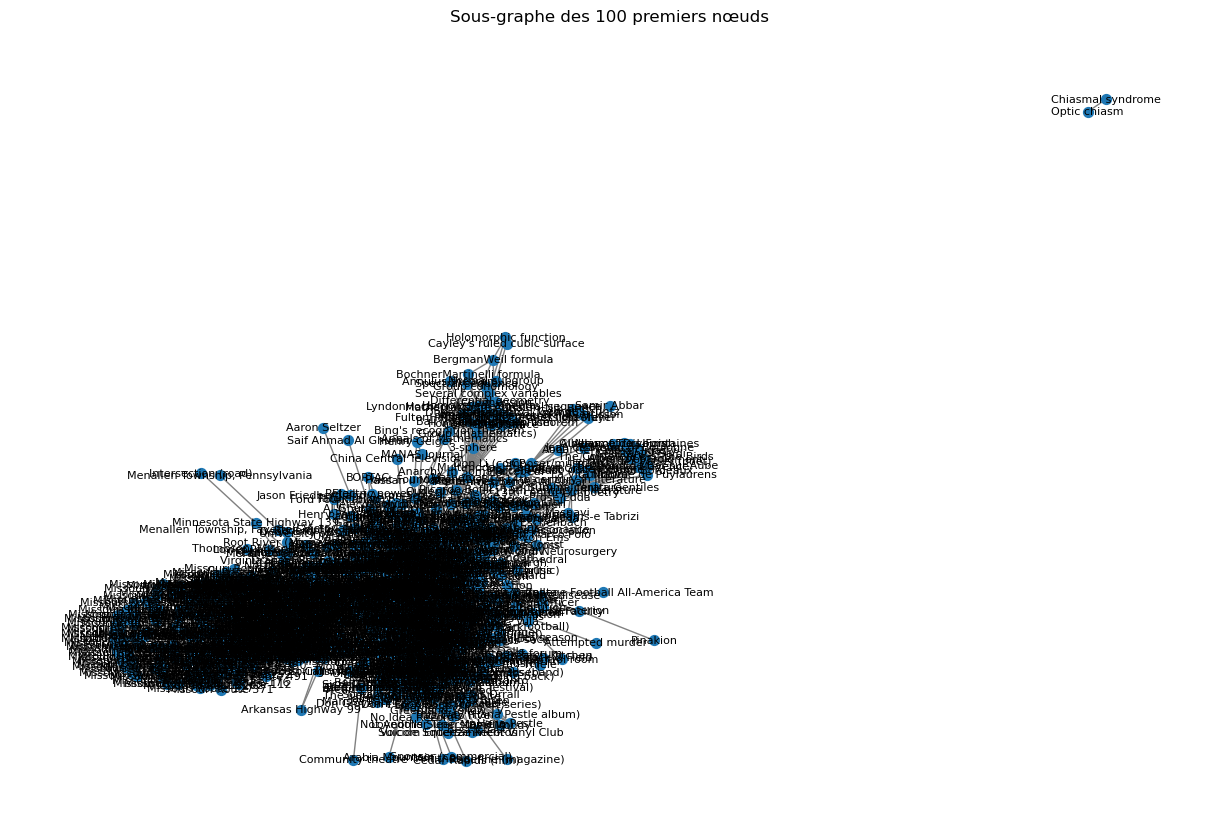

In [13]:
# Visualiser une sous-partie du graphe
subgraph = G.subgraph(list(G.nodes)[:1000])  # Prenez un sous-graphe avec 100 nœuds
pos = nx.spring_layout(subgraph, seed=42)  # Layout pour la visualisation

print(f"Nombre de nœuds : {subgraph.number_of_nodes()}")
print(f"Nombre d'arêtes : {subgraph.number_of_edges()}")


plt.figure(figsize=(12, 8))
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    labels={node: G.nodes[node]["name"] for node in subgraph.nodes},  # Utiliser les noms des pages
    node_size=50,
    font_size=8,
    edge_color="gray",
)
plt.title("Sous-graphe des 100 premiers nœuds")
plt.show()

In [70]:
# 1. Vérifier les cycles
try:
    cycle = nx.find_cycle(subgraph)
    print(f"Le graphe contient un cycle : {cycle}")
except nx.NetworkXNoCycle:
    print("Le graphe ne contient aucun cycle.")

# 2. Vérifier si le graphe est un DAG
if nx.is_directed_acyclic_graph(subgraph):
    print("Le graphe est un DAG.")
else:
    print("Le graphe n'est pas un DAG.")

# 3. Trouver les self-loops
self_loops = list(nx.selfloop_edges(subgraph))
print(f"Nombre de nœuds connectés à eux-mêmes (self-loops) : {len(self_loops)}")
if self_loops:
    print(f"Nœuds avec self-loops : {self_loops}")

# 4. Trouver les composantes connectées
connected_components = list(nx.connected_components(subgraph))
print(f"Nombre de composantes connectées : {len(connected_components)}")
component_sizes = [len(component) for component in connected_components]
print(f"Taille des composantes connectées : {component_sizes}")

Le graphe contient un cycle : [(64, 2288), (2288, 66769), (66769, 64)]
Le graphe n'est pas un DAG.
Nombre de nœuds connectés à eux-mêmes (self-loops) : 6
Nœuds avec self-loops : [(471303, 471303), (272754, 272754), (1174771, 1174771), (9227, 9227), (9587, 9587), (315158, 315158)]
Nombre de composantes connectées : 2
Taille des composantes connectées : [2, 998]


In [72]:
import networkx as nx
import plotly.graph_objects as go

# Visualiser une sous-partie du graphe
subgraph = G.subgraph(list(G.nodes)[:1000])  # Prenez un sous-graphe avec 400 nœuds
pos = nx.spring_layout(subgraph, seed=42)  # Layout pour la visualisation

# Préparer les nœuds
node_x = []
node_y = []
node_text = []

for node, coords in pos.items():
    node_x.append(coords[0])
    node_y.append(coords[1])
    node_text.append(G.nodes[node].get("name", f"Node {node}"))  # Infobulle pour chaque nœud

# Préparer les arêtes
edge_x = []
edge_y = []

for edge in subgraph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])  # None pour interrompre la ligne
    edge_y.extend([y0, y1, None])

# Créer le tracé des arêtes
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color="#888"),
    hoverinfo="none",
    mode="lines"
)

# Créer le tracé des nœuds
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers",
    marker=dict(
        size=10,
        color="#1f78b4",
        line_width=2
    ),
    text=node_text,
    hoverinfo="text"
)

# Créer la figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Sous-graphe interactif",
                    titlefont_size=16,
                    showlegend=False,
                    hovermode="closest",
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False),
                ))

fig.show(renderer="browser")

## Test of the different methods on 1000 points

Suppression des arêtes: 100%|██████████| 100/100 [5:29:41<00:00, 197.82s/it] 
C:\Users\antoi\AppData\Local\Temp\ipykernel_37720\3829484942.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("hsv", len(clusters))


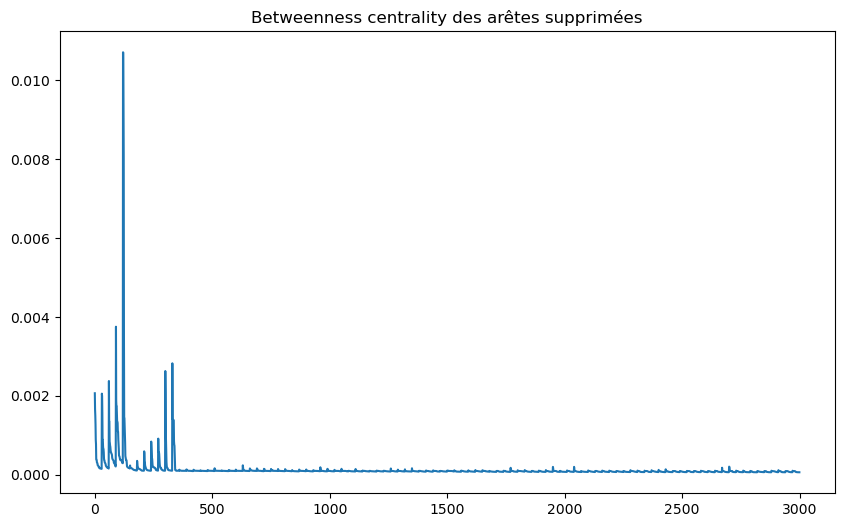

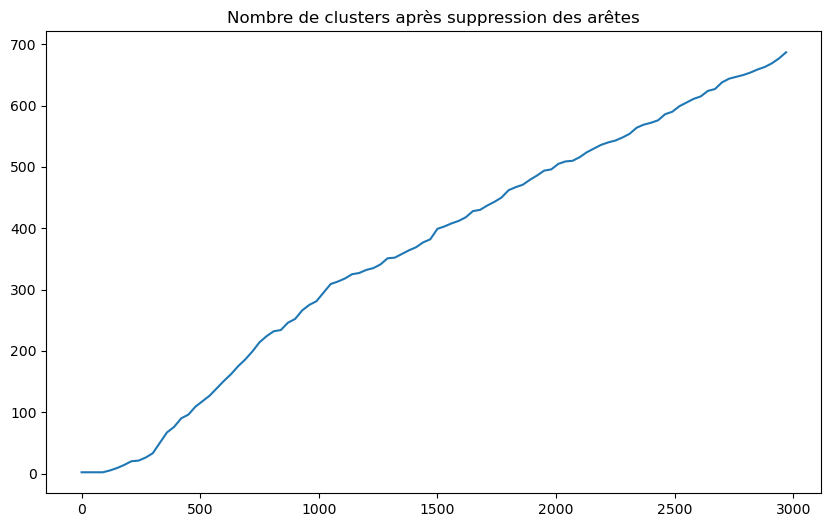

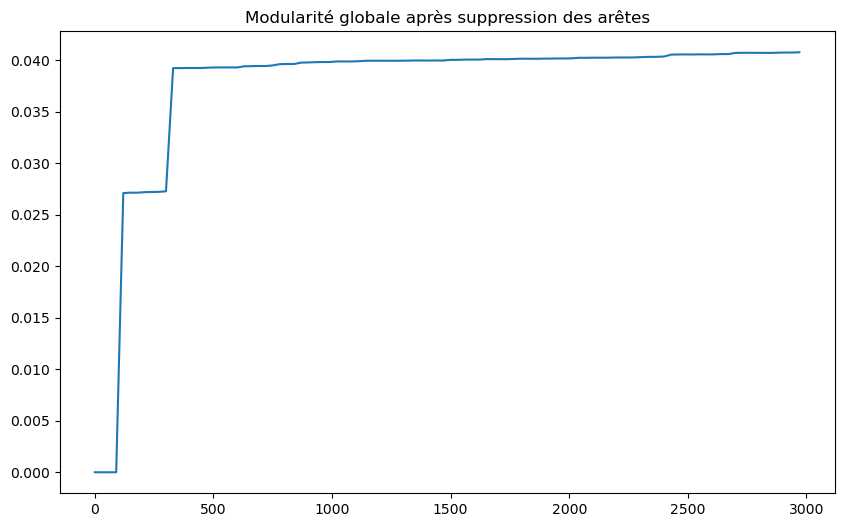

In [ ]:
number_edges_to_compute = 30
num_edges_to_remove = 3000
k=1000
G2,clusters,betwenness, liste_number_clusters, liste_partial_clusters = remove_edges_with_highest_betweenness_networkx(subgraph,number_edges_to_compute=number_edges_to_compute, num_edges_to_remove=num_edges_to_remove, k=k)
# Visualiser les clusters
#visualize_clusters(G2, clusters)
#visualize_clusters(G, clusters)
visualize_clusters_plotly(subgraph, clusters)

plt.figure(figsize=(10, 6))
plt.title("Betweenness centrality des arêtes supprimées")
plt.plot(betwenness)

plt.figure(figsize=(10, 6))
plt.title("Nombre de clusters après suppression des arêtes")
plt.plot(range(0,num_edges_to_remove,number_edges_to_compute),liste_number_clusters)

plt.figure(figsize=(10, 6))
plt.title("Modularité globale après suppression des arêtes")
plt.plot(range(0,num_edges_to_remove,number_edges_to_compute),list(global_modularity(partial_clusters, subgraph) for partial_clusters in liste_partial_clusters))


In [ ]:
save_outputs(subgraph, clusters, betwenness, liste_number_clusters, liste_partial_clusters, custom_string="Global_10000_premiers_noeuds", params={"number_edges_to_compute": number_edges_to_compute, "num_edges_to_remove": num_edges_to_remove, "k": k})

Tous les outputs ont été sauvegardés dans le répertoire : Clustering_2024-12-09_Global_10000_premiers_noeuds


2
Cluster 1 : syndrome chiasm 10772 optic chiasmal 0...


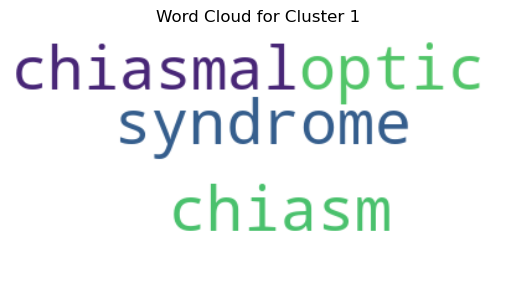

2
Cluster 2 : kleroterion pinakion 2 1...


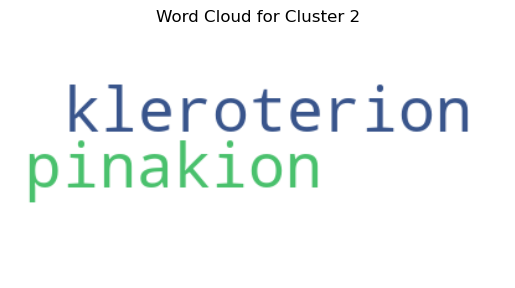

34
Cluster 3 : algebraic 1101555 ball ruled cohomology 1101894 r 3sphere codimension main cayleys homeomorphism for...


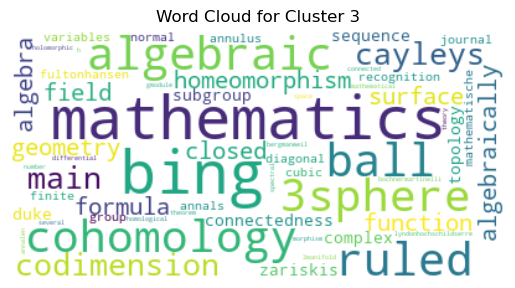

2
Cluster 4 : township fayette county menallen 11 pennsylvania 285865...


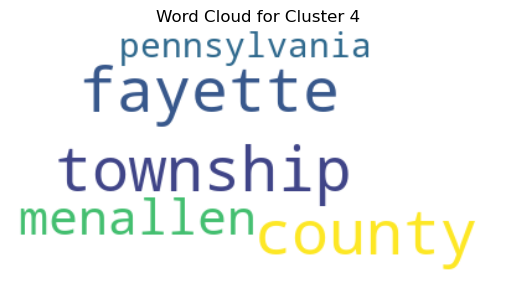

329
Cluster 5 : 36 279603 308258 118 1789552 265 23 744 bethany 107 279607 289633 80 293184 caney meramec 108297 cam...


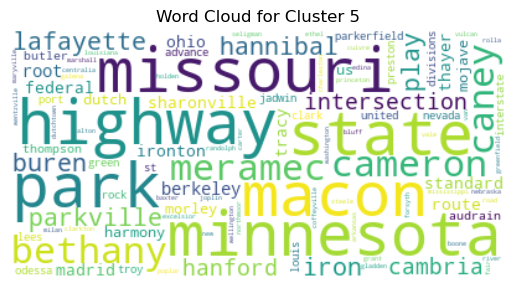

1
Cluster 6 : lower school parker 18...


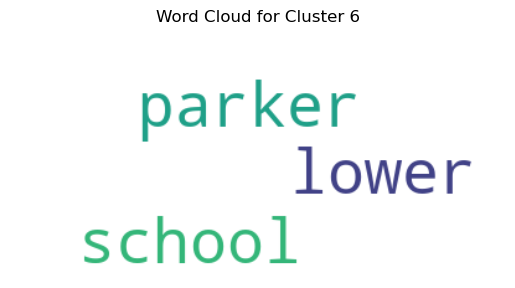

1
Cluster 7 : missouri 19 lecoma...


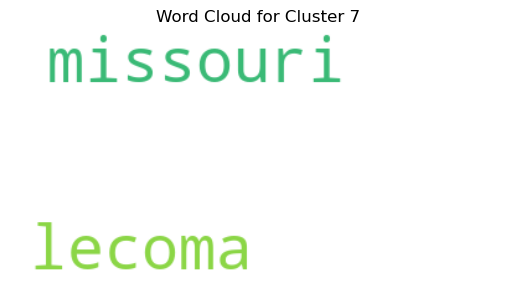

549
Cluster 8 : 961656 230038 segall horace film venture studio bolinger 23 218095 disease 1178953 riverside tv 2425...


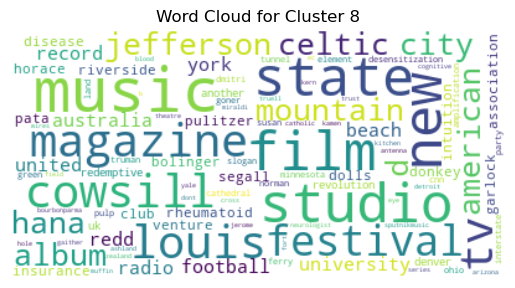

4
Cluster 9 : missouri kentucky 1056874 80 26 route end 709195 virginia state dead 327757...


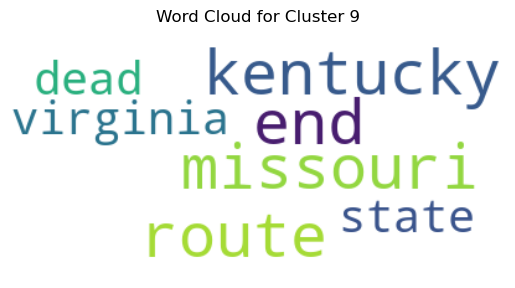

3
Cluster 10 : missouri 153 county 162 279721 madrid 32 route new 325118...


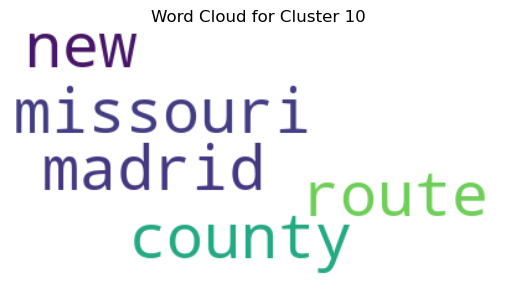

4
Cluster 11 : mohammed tyre 105058 lebanon 59 bin 133985 59969 al samir ali abbar...


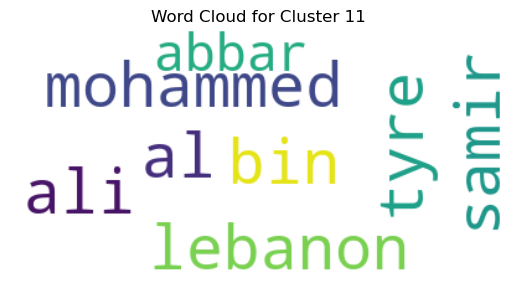

5
Cluster 12 : 385084 79 phillies thoenen season dick 386776 innings pitched earned run philadelphia 386931 average...


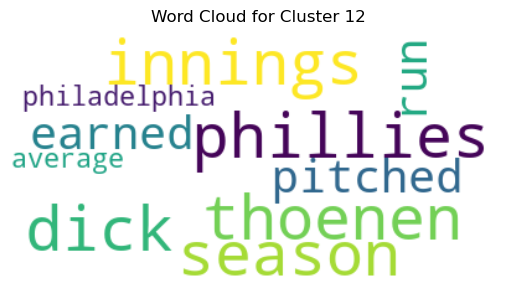

32
Cluster 13 : poetry nibelungenlied 1638136 dante alighieri hlinand rudolf gervase 155862 shamse 1109733 diwane de...


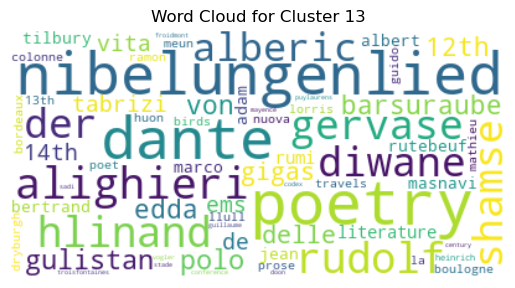

2
Cluster 14 : 91 manas 92 henry journal geiger...


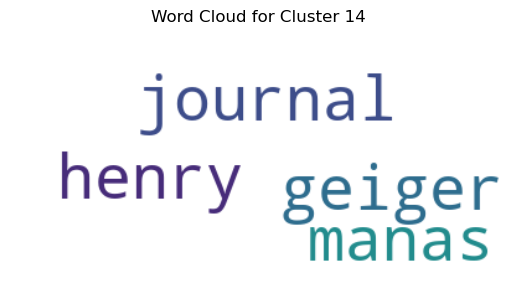

5
Cluster 15 : george sverrisson nik 1022682 jojo li 1239665 brtsch 101 skli mayer don 211967 1442600 composermusic...


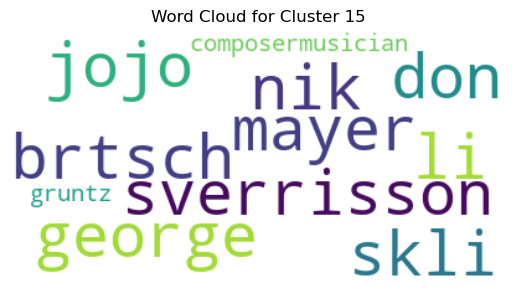

2
Cluster 16 : jason 1064745 aaron friedberg seltzer and 115...


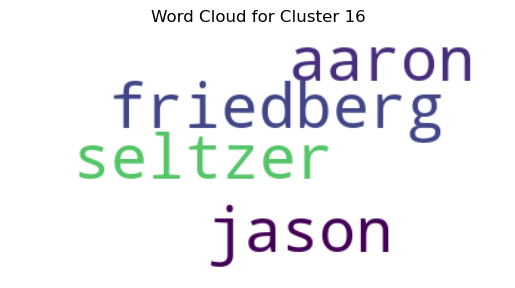

2
Cluster 17 : clark alabama 1512933 running ken back 117 evergreen...


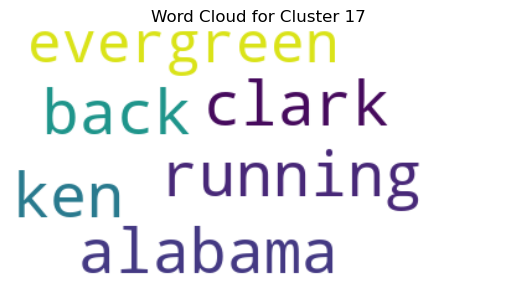

1
Cluster 18 : ben rudolph 118...


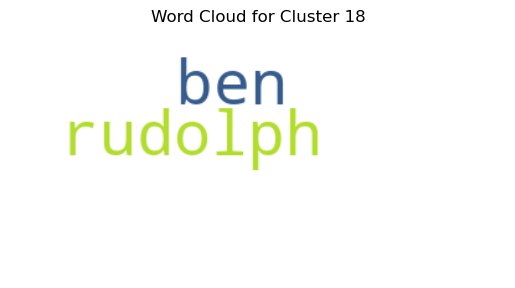

2
Cluster 19 : college 123 team 1970 burns leon football allamerica 1540850...


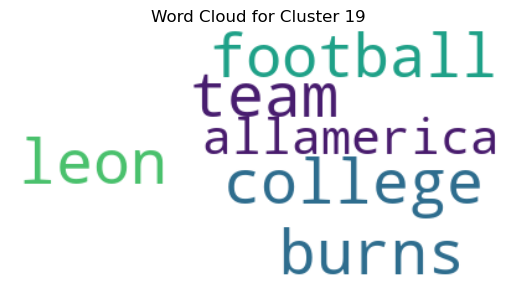

1
Cluster 20 : roger bacon 65572...


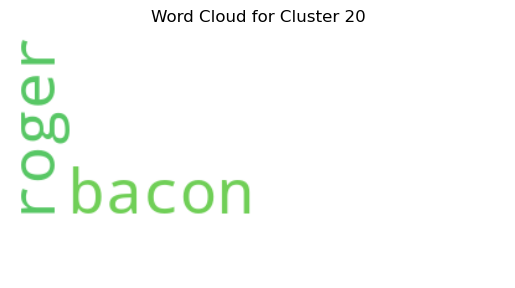

1
Cluster 21 : von wolfram 184691 eschenbach...


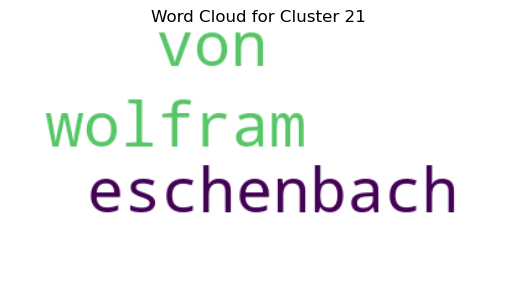

1
Cluster 22 : 76 carolina north julian...


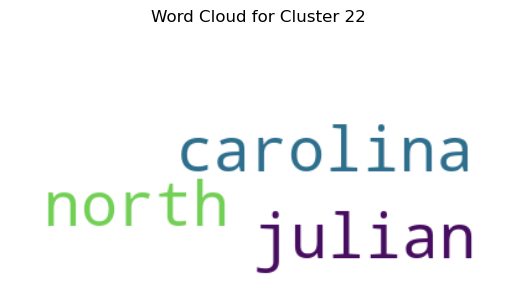

1
Cluster 23 : beautification highway 332187...


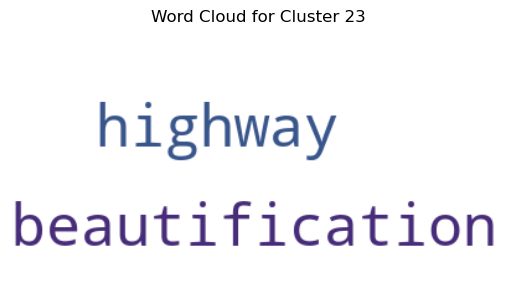

1
Cluster 24 : grosseteste robert 68295...


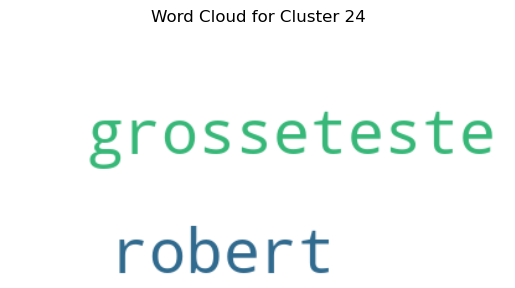

1
Cluster 25 : 598775 sortition...


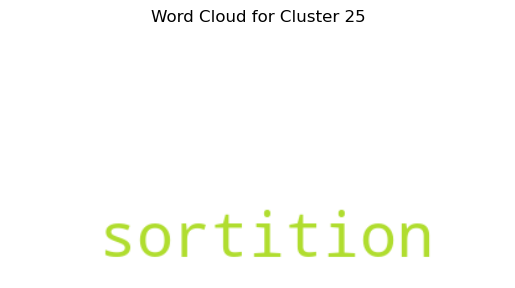

1
Cluster 26 : 279384 chautauqua county kansas...


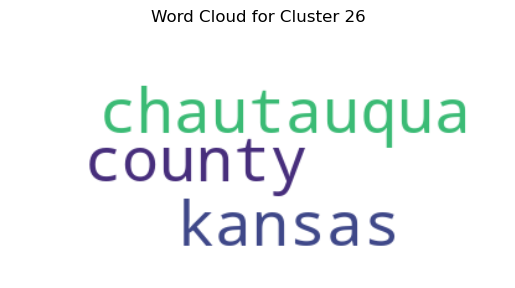

1
Cluster 27 : abraham 597128 maslow...


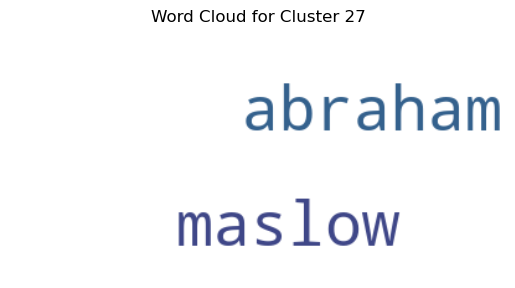

3
Cluster 28 : 1545530 touchdown 1545357 korey 1545756 stringer fumble...


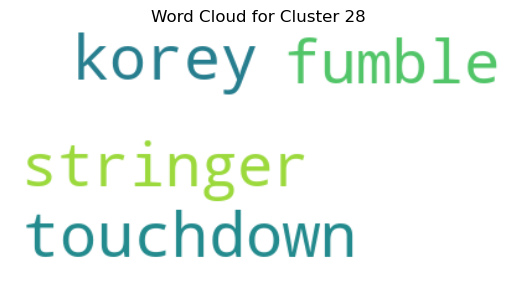

1
Cluster 29 : potosi 279701 missouri...


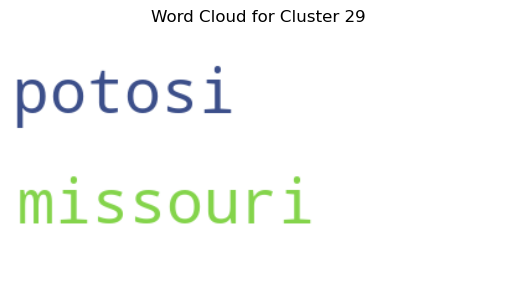

1
Cluster 30 : borgeaud pierreyves 658748...


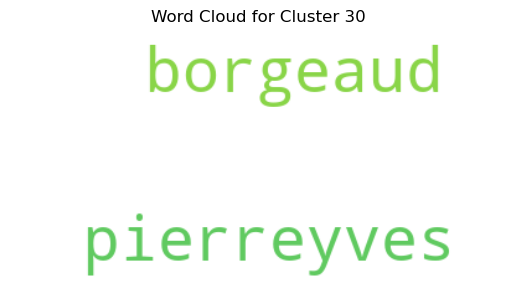

1
Cluster 31 : sack 1545544 quarterback...


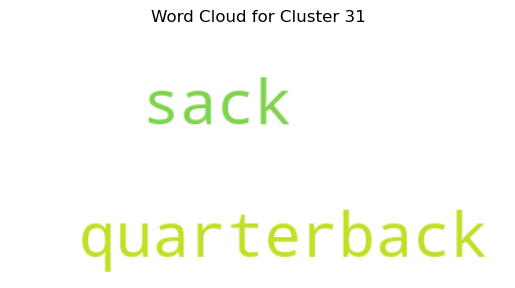

1
Cluster 32 : yard 1535491...


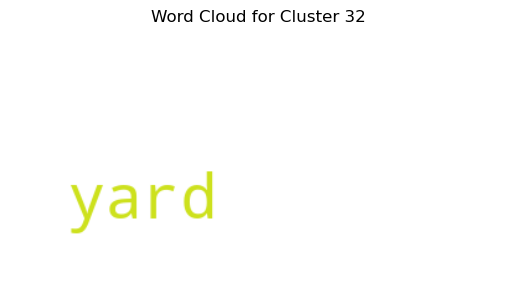

1
Cluster 33 : 421 route 298517 us...


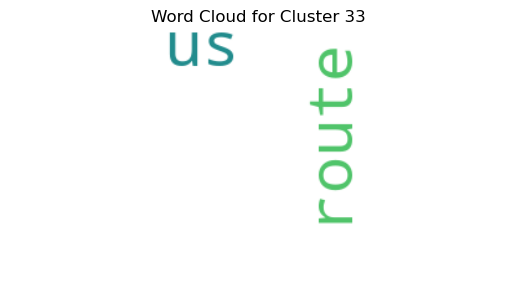

1
Cluster 34 : average 1099344...


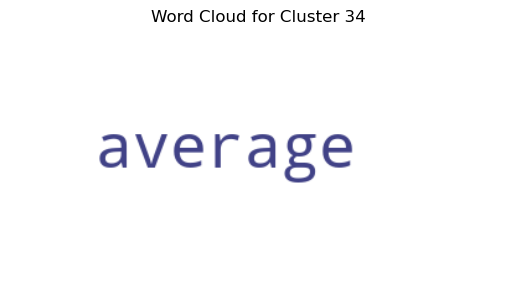

1
Cluster 35 : contra summa 59360 gentiles...


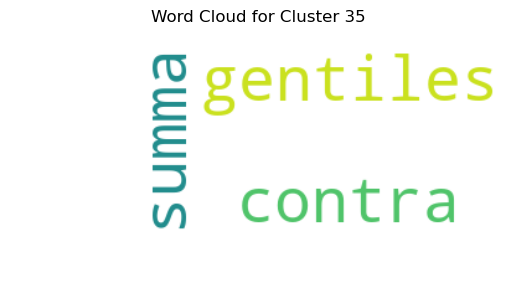

In [71]:
dictionary_clusters={}
for i in range(len(clusters)):
    liste=[]
    for j in clusters[i]:
        liste.append(names[0][j])
    dictionary_clusters[i] = liste


# Créez un Word Cloud pour chaque cluster
for cluster_id, cluster_phrases in dictionary_clusters.items():
    # Combinez toutes les phrases du cluster
    print(len(cluster_phrases))
    text = ' '.join(cluster_phrases).lower()
    text = ' '.join(set(text.split()))
    text = re.sub(r'[^\w\s]', '', text)  # Supprime les caractères non alphanumériques
    text = text.lower()
    print(f"Cluster {cluster_id + 1} : {text[:100]}...")
    # Générez le Word Cloud
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

    # Affichez le Word Cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id+1}")
    plt.show()

Suppression des arêtes: 100%|██████████| 85/85 [08:45<00:00,  6.18s/it]
C:\Users\antoi\AppData\Local\Temp\ipykernel_33364\1547160461.py:69: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



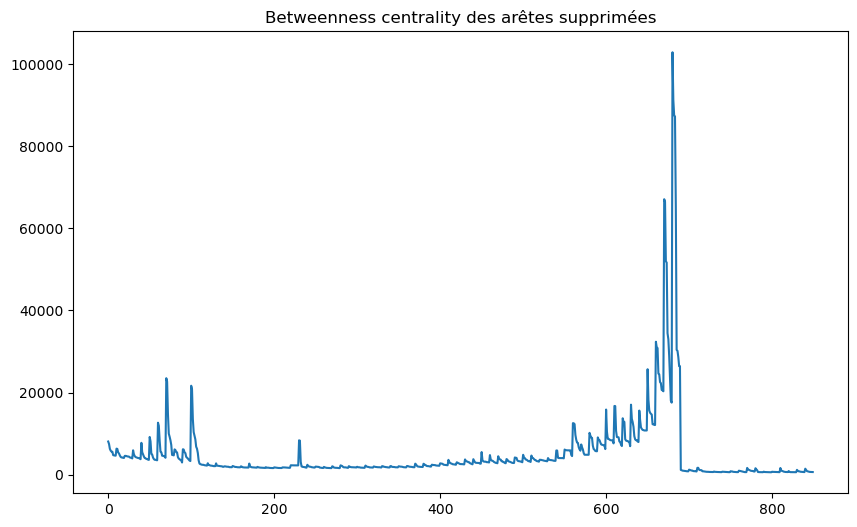

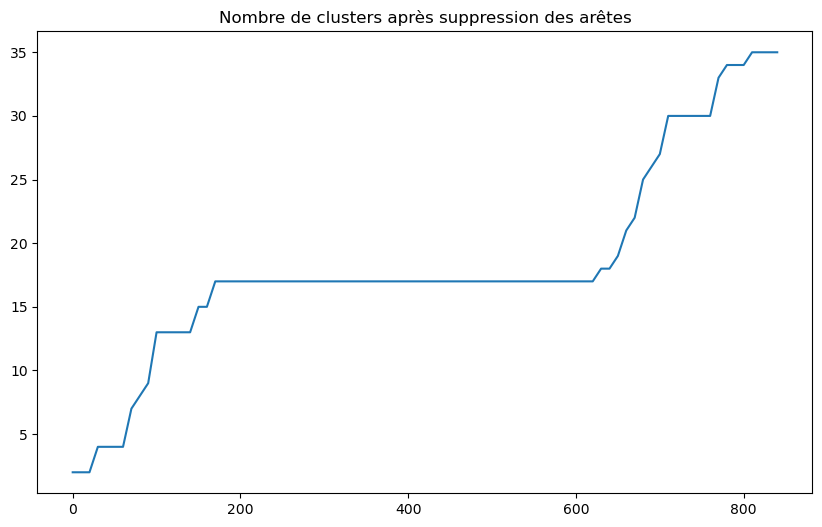

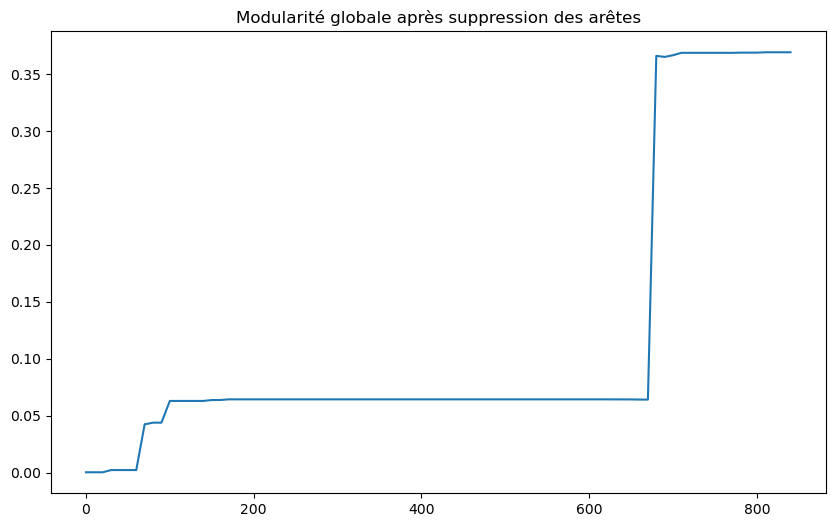

In [69]:
number_edges_to_compute = 10
num_edges_to_remove = 850
k=None
G2,clusters,betwenness, liste_number_clusters, liste_partial_clusters = remove_edges_with_highest_betweenness_Brandes(subgraph,number_edges_to_compute=number_edges_to_compute, num_edges_to_remove=num_edges_to_remove, k=k)
# Visualiser les clusters
#visualize_clusters(G2, clusters)
#visualize_clusters(G, clusters)
visualize_clusters_plotly(subgraph, clusters)

plt.figure(figsize=(10, 6))
plt.title("Betweenness centrality des arêtes supprimées")
plt.plot(betwenness)

plt.figure(figsize=(10, 6))
plt.title("Nombre de clusters après suppression des arêtes")
plt.plot(range(0,num_edges_to_remove,number_edges_to_compute),liste_number_clusters)

plt.figure(figsize=(10, 6))
plt.title("Modularité globale après suppression des arêtes")
plt.plot(range(0,num_edges_to_remove,number_edges_to_compute),list(global_modularity(partial_clusters, subgraph) for partial_clusters in liste_partial_clusters))




Cluster 1: syndrome 10772 optic chiasmal 0 chiasm...


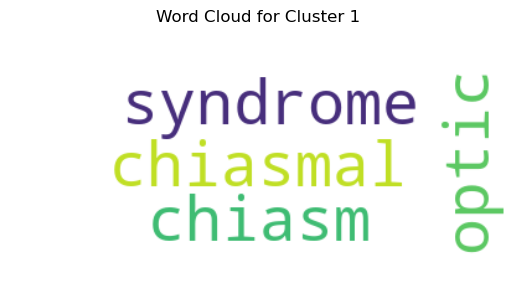

Cluster 2: pinakion 1 2 kleroterion...


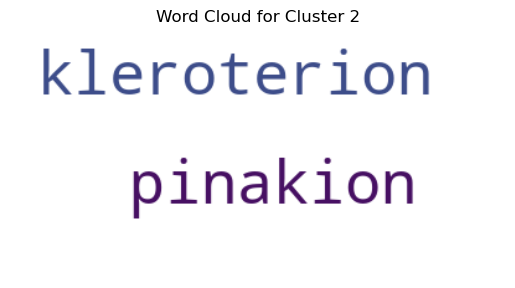

Cluster 3: 4 1101491 7 9 1101987 ruled journal 1103745 1102234 sequence 1102709 group 1101324 several 1101945 f...


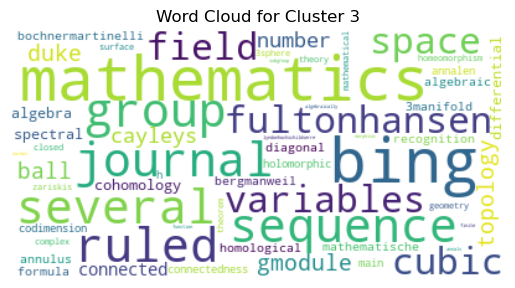

Cluster 4: 285865 11 menallen fayette township county pennsylvania...


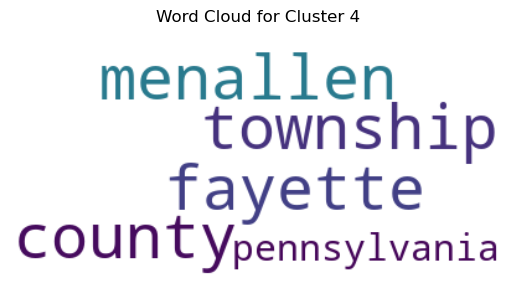

Cluster 5: 79 madrid 279711 279796 dent 279776 river 279785 42 road 76 dutch 9 keokuk 279619 279813 1535280 308...


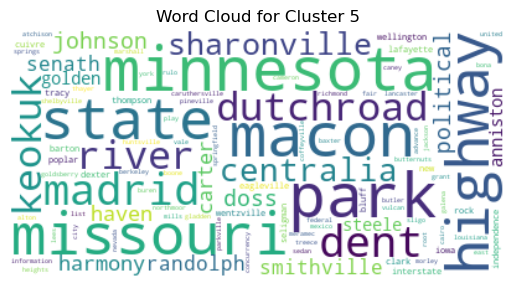

Cluster 6: school lower parker 18...


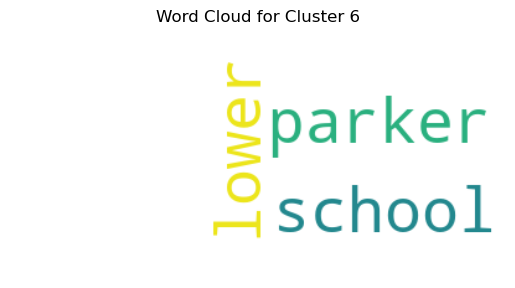

Cluster 7: missouri 19 lecoma...


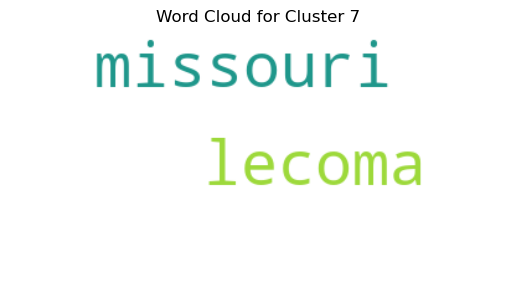

Cluster 8: stooges 4 62 movie 42 1180883 139897 1683127 1176053 foundation another group steven bolt 1961 51 re...


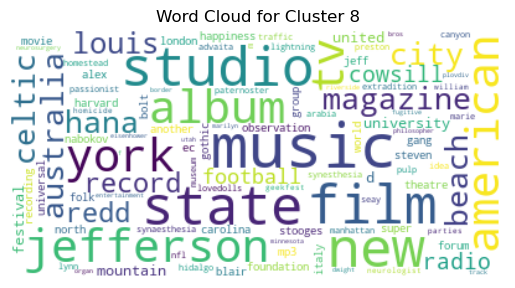

Cluster 9: 80 end dead virginia 327757 missouri 1056874 route state kentucky 26 709195...


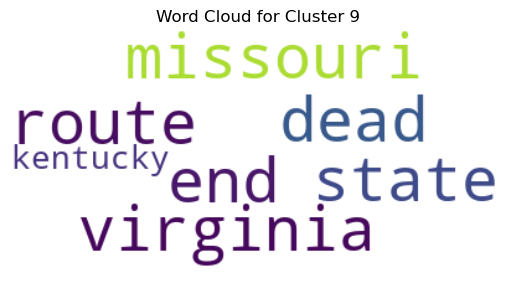

Cluster 10: 162 325118 madrid missouri new route 153 county 279721 32...


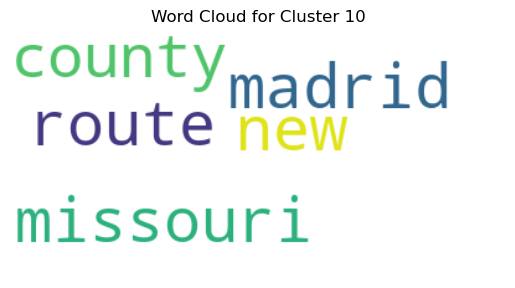

Cluster 11: 133985 lebanon mohammed al bin samir 59 105058 abbar ali tyre 59969...


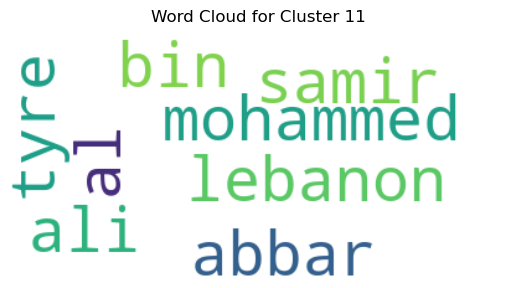

Cluster 12: 386776 innings 79 386931 phillies earned average pitched season 385084 thoenen philadelphia run dick...


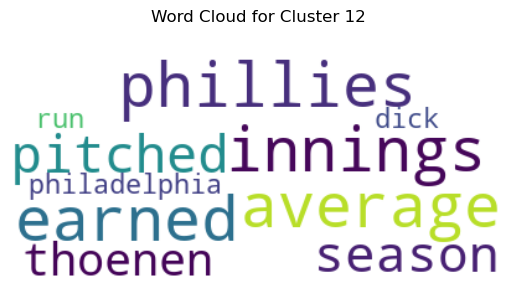

Cluster 13: mayence der prose lorris tilbury 974280 llull 156094 rudolf boulogne ramon 12th travels 369447 guill...


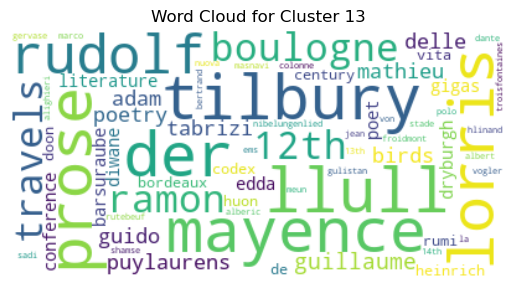

Cluster 14: 92 geiger journal 91 manas henry...


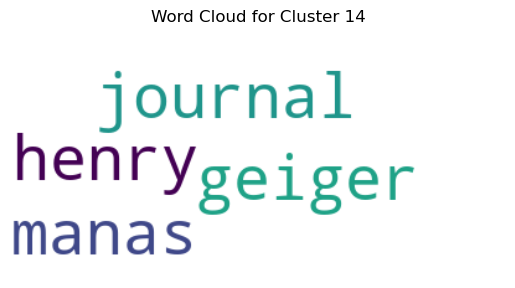

Cluster 15: li composermusician 1239665 mayer 211967 1022682 sverrisson 101 jojo gruntz brtsch george nik don sk...


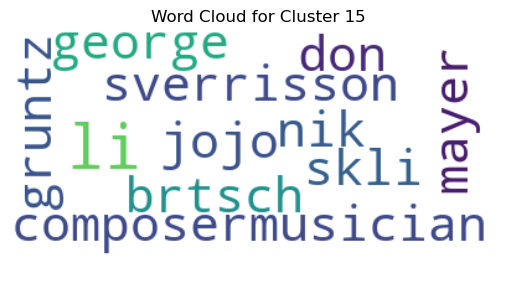

Cluster 16: jason 115 seltzer and aaron 1064745 friedberg...


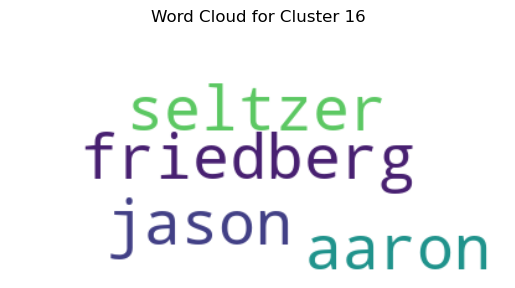

Cluster 17: running 1512933 clark back ken 117 evergreen alabama...


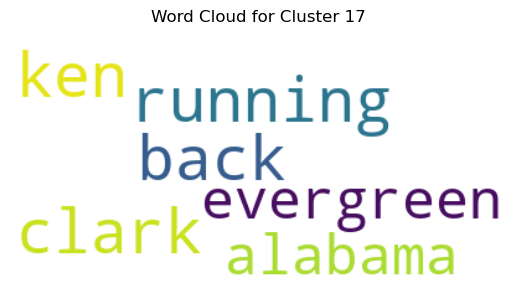

Cluster 18: rudolph 118 ben...


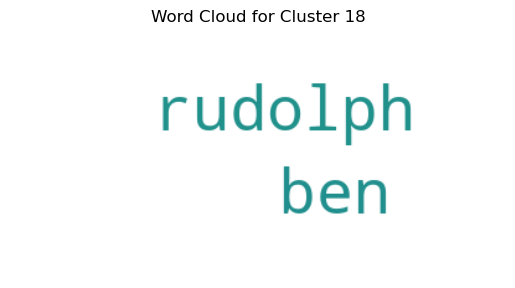

Cluster 19: 123 college football team allamerica 1540850 1970 burns leon...


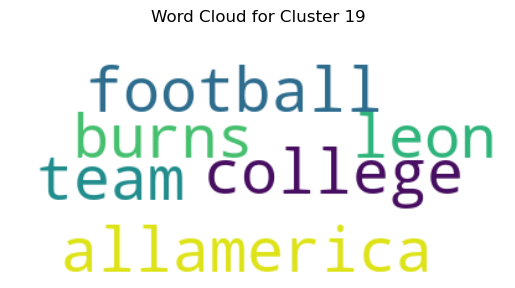

Cluster 20: 65572 roger bacon...


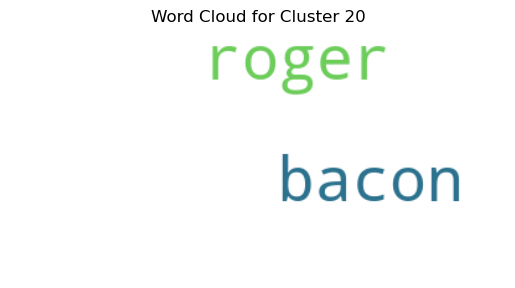

Cluster 21: von wolfram 184691 eschenbach...


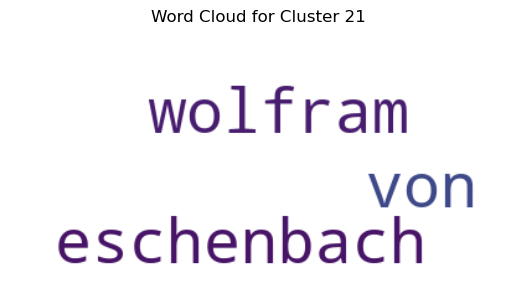

Cluster 22: carolina 76 north julian...


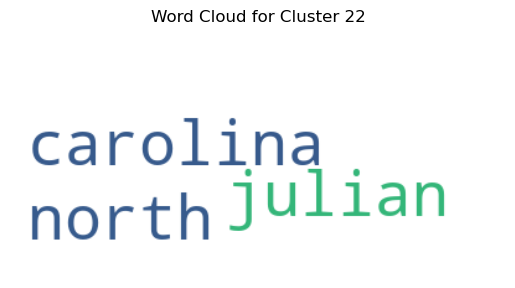

Cluster 23: highway beautification 332187...


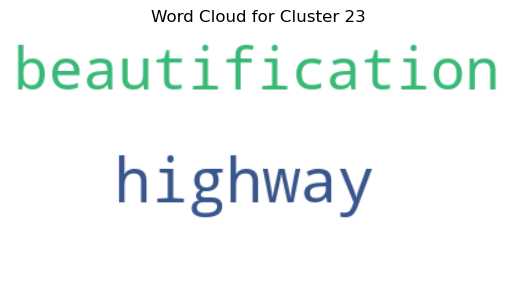

Cluster 24: robert grosseteste 68295...


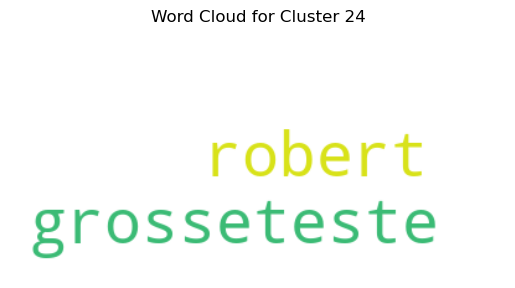

Cluster 25: 598775 sortition...


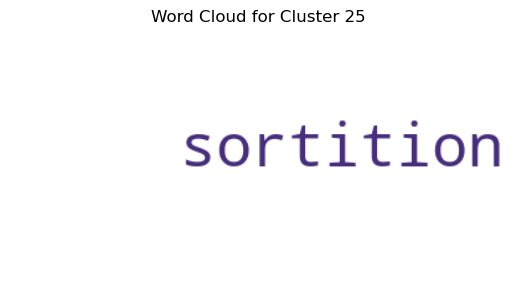

Cluster 26: 279384 chautauqua county kansas...


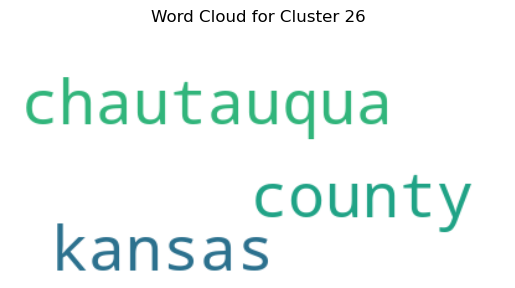

Cluster 27: abraham 597128 maslow...


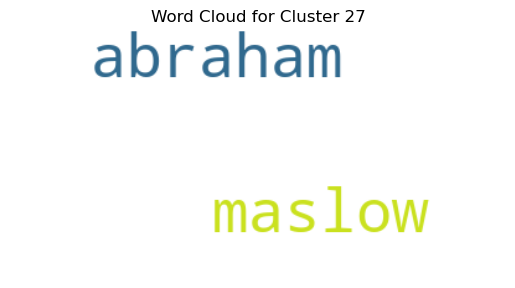

Cluster 28: 1545756 1545530 fumble korey touchdown stringer 1545357...


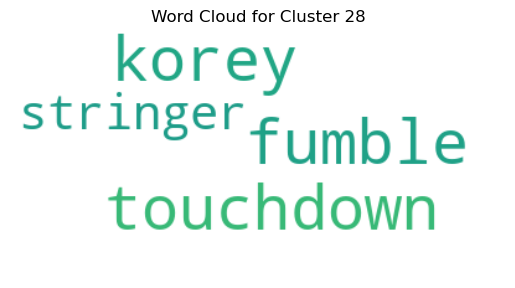

Cluster 29: 279701 missouri potosi...


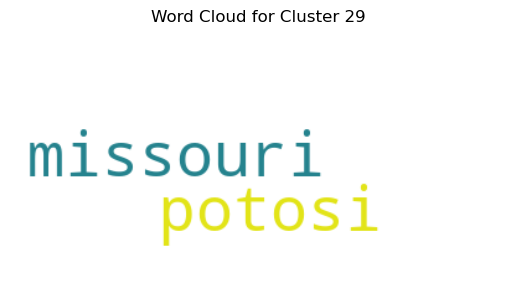

Cluster 30: pierreyves borgeaud 658748...


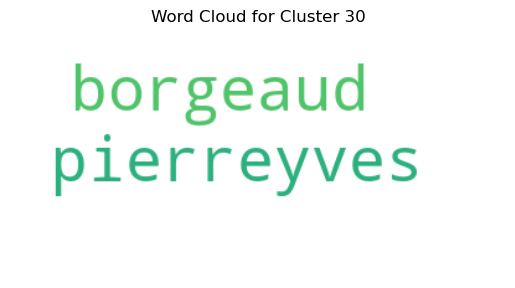

Cluster 31: 1545544 sack quarterback...


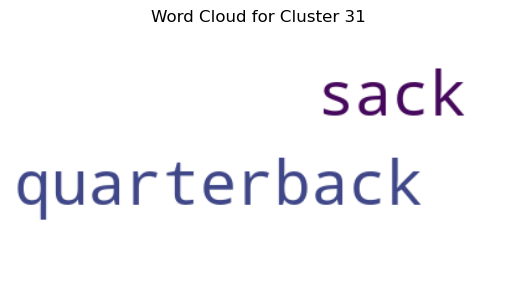

Cluster 32: 1535491 yard...


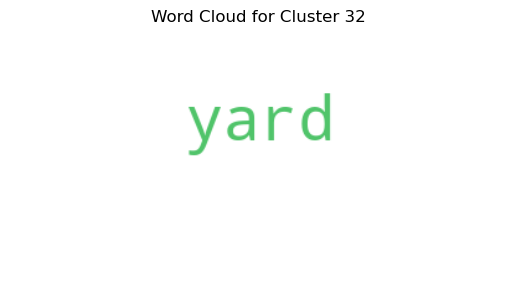

Cluster 33: route 298517 421 us...


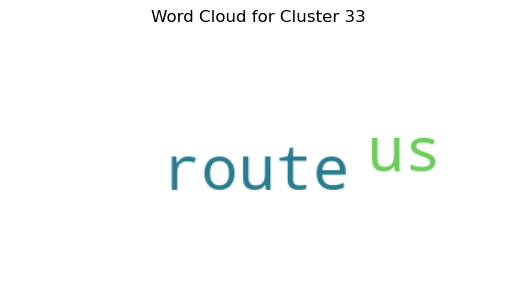

Cluster 34: 1099344 average...


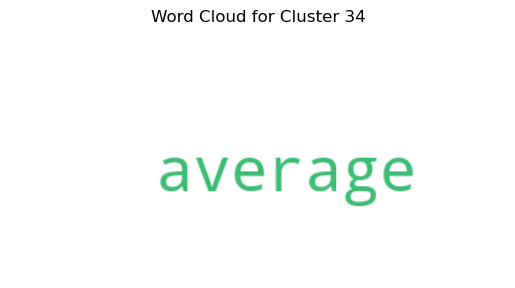

Cluster 35: 59360 contra gentiles summa...


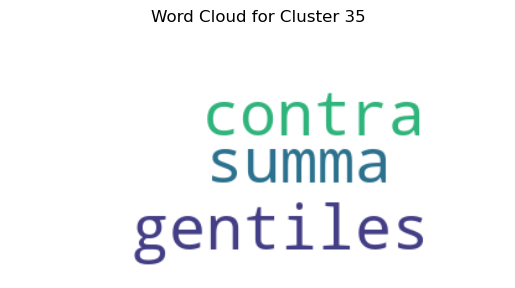

In [71]:

save_outputs(subgraph, clusters, betwenness, liste_number_clusters, liste_partial_clusters, custom_string="Global_1000_premiers_noeuds_brut_force", params={"number_edges_to_compute": number_edges_to_compute, "num_edges_to_remove": num_edges_to_remove, "k": k})

dictionary_clusters = create_and_generate_wordclouds(clusters, names)


Suppression des arêtes: 100%|██████████| 100/100 [24:59<00:00, 14.99s/it]
C:\Users\antoi\AppData\Local\Temp\ipykernel_33364\3631718370.py:69: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



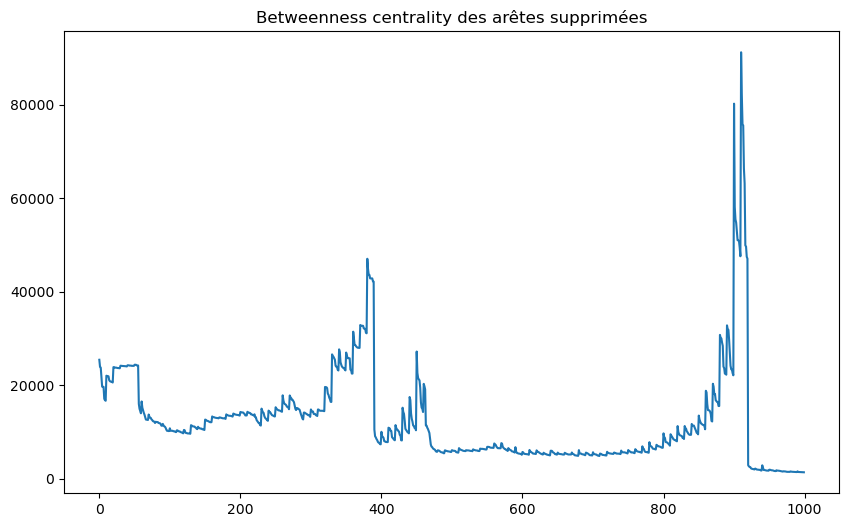

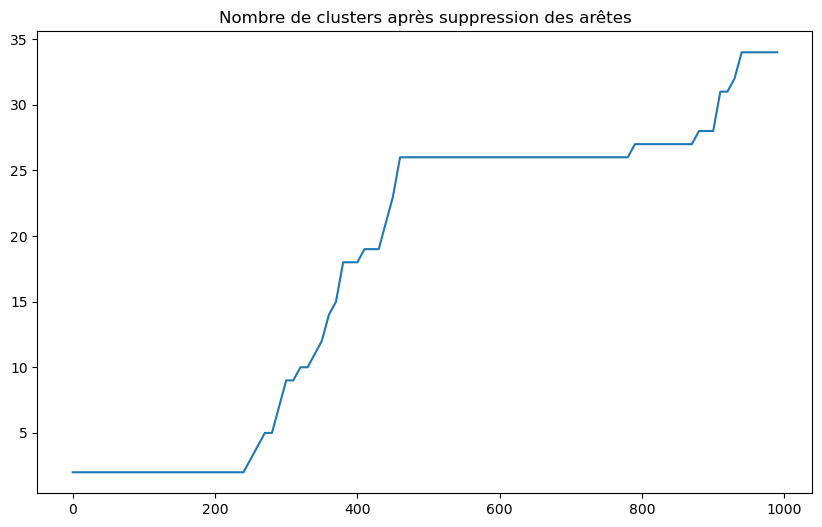

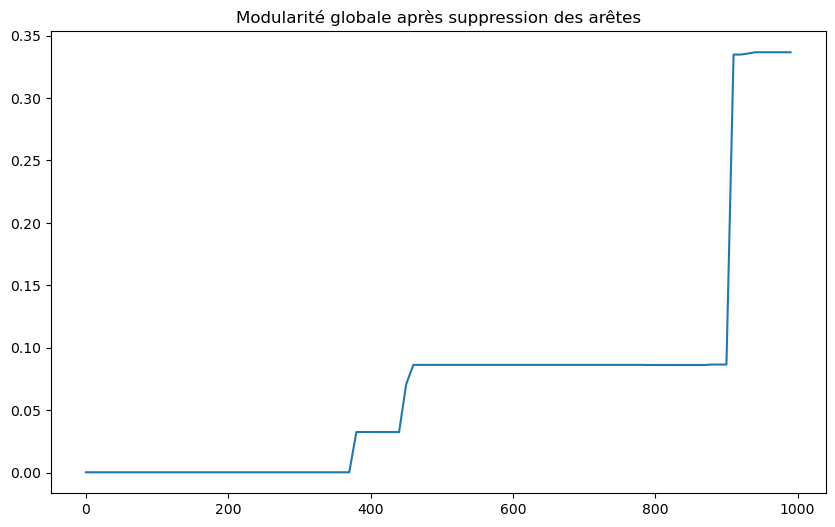

In [66]:
number_edges_to_compute = 10
num_edges_to_remove = 1000
k=None
G2,clusters,betwenness, liste_number_clusters, liste_partial_clusters = remove_edges_with_highest_betweenness_brut_force(subgraph,number_edges_to_compute=number_edges_to_compute, num_edges_to_remove=num_edges_to_remove, k=k)
# Visualiser les clusters
#visualize_clusters(G2, clusters)
#visualize_clusters(G, clusters)
visualize_clusters_plotly(subgraph, clusters)

plt.figure(figsize=(10, 6))
plt.title("Betweenness centrality des arêtes supprimées")
plt.plot(betwenness)

plt.figure(figsize=(10, 6))
plt.title("Nombre de clusters après suppression des arêtes")
plt.plot(range(0,num_edges_to_remove,number_edges_to_compute),liste_number_clusters)

plt.figure(figsize=(10, 6))
plt.title("Modularité globale après suppression des arêtes")
plt.plot(range(0,num_edges_to_remove,number_edges_to_compute),list(global_modularity(partial_clusters, subgraph) for partial_clusters in liste_partial_clusters))

In [61]:
visualize_clusters_plotly(subgraph, clusters)

C:\Users\antoi\AppData\Local\Temp\ipykernel_33364\3631718370.py:69: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

